# USS Pension Scheme calculations
Notebook to analyse benefits/returns from the proposed USS scheme from April 2024 and compare with those from a self-invested personal pension (SIPP) and the current scheme, as a function of salary and age.

This notebook runs python 3 code.

In [618]:
#Note book setup

#enables autosaving every 30s. Change "30" to "0" to disable autosaving.
%autosave 30

#use inline interactive plots
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numbers

Autosaving every 30 seconds


## Introduction

The USS scheme has two main parts: a defined benefit (DB) part that promises a certain payment in retirement plus a cash lump sum, and a defined contribution (DC) part where payments in are invested and the amount available in retirement is the value of these investments at that time. There is no option about which to pay into - salary below a threshold is paid into the defined benefit part and salary above goes to the defined contribution part. 

For comparison, I consider the expected return for someone paying their USS contribution into a self-invested personal pension (SIPP) instead (not getting the employer contribution or national insurance relief), and buying an inflation-linked annuity at retirement age (for comparability with getting a pension from USS). 

For both the USS DC part and SIPP investor, I consider someone using a fairly "moderate" 60% stocks/40% government bond portfolio and someone invested "aggressively" in 100% equities. Note the actual return may differ substantially from the expected return and this isn't considered. (The DC fund options include 100% equities funds and other mixed asset or bond funds, and a 60% stocks/40% bond portfolio's expected return should sit somewhere in the range of expected returns from these funds, but doesn't correspond to any one in particular.) The USS DC part is assumed to grow at the same rate as investments into the SIPP and have the same charges (but benefit from having the added employer contribution and NI relief). Assuming constant asset allocation through to retirement age is a simplification and results are just meant to be illustrative.

For ease of comparison, the USS DB cash lump sum and USS DC parts are assumed to be used to purchase a single lifetime inflation-linked annuity for someone at retirement age.

All amounts are given in units of current total salary (i.e. the payments that would be expected for each £1 of salary earnt) in inflation-adjusted terms. For simplicity it is assumed that all future USS payments increase following inflation, approximating that the inflation caps do not come into play.

## Calculation parameters

In [619]:
#Proposed new scheme parameters, based on those on 4/11/23 at https://ussconsultation2023.co.uk/members/proposals and https://www.uss.co.uk/about-us/valuation-and-funding/2023-valuation?search=dfd34ed6-8d04-4d45-a0ec-1af00a3b1f2a
uss_new = { 
    'db_cont':     0.061,       #contribution rate for DB scheme, 6.1%. It is assumed this will stay the same for the DC part, but it's not confirmed, and it seems optimistic to think the employer contribution to the DC part would increase to 13.9%.
    'db_pens':     1/75.,       #fraction of salary paid as pension
    'db_cash':     3/75.,       #fraction of salary that can be taken as lump sum cash
    'db_empl':     0.145,       #employer contribution rate for DB scheme
    'dc_cont':     0.061,       #contribution rate for DC scheme.
    'dc_amount':   0.2,         #amount paid into defined contribution scheme (proposed to stay at 20% of salary, though this is not confirmed)
    'sal_thres':   70308        #salary threshold for changing from defined benefit to defined contribution
}

#Old scheme parameters
uss_old = {
    'db_cont':     0.098,
    'db_pens':     1/85.,
    'db_cash':     3/85.,
    'dc_cont':     0.098,
    'dc_amount':   0.2,
    'sal_thres':   41004     #the 2023/4 value from https://www.uss.co.uk/glossary#Glossary_S
}

#SIPP parameters
#Future expected asset returns set to historical global returns over 1900-2022 from the Credit Suisse Yearbook 2023 summary (though I cannot now find a working link to it)
eq_exp_growth =    0.049   #expected real equities growth, 5.0%/yr, minus 0.1% assumed investment charges
bonds_exp_growth = 0.016   #expected real government bonds growth, 1.7%/yr (estimated from fig.11 of the CS Yearbook), minus 0.1% assumed investment charges
eq_frac_typ = 0.6          #fraction invested in equities for a typical investor, 60% (the remainder being in bonds)
eq_frac_agg = 1.0          #fraction invested in equities for "aggressive" investor
annuity_yield = 0.055      #best quote from https://www.moneyadviceservice.org.uk/en/tools/annuities for present single lifetime RPI-adjusted annuity for healthy 68 year old (in Oct 2023).

## Estimating expected future pension
By no. of years until retirement, per £ of salary.

### Function definitions

In [620]:
#Function to calculate growth of £1 of invested assets (for USS DC/SIPP investments):
#eq_frac - fraction of investments in equities
#n - no. of years until retirement
def investment_value(eq_frac,n):
    return eq_frac*(1+eq_exp_growth)**n + (1-eq_frac)*(1+bonds_exp_growth)**n

#USS lump sum annuity purchase
#uss_params is either uss_new or uss_old from above
def uss_ls(uss_params):
    return uss_params['db_cash']*annuity_yield

#USS DC part. 
#salary arg is in £
#Returns:
#pens_dc - pension per unit invested into DC scheme
#dc_frac - fraction of employee salary invested in DC scheme, including employer contribution
def uss_dc(uss_params,salary,eq_frac,n):
    pens_dc = investment_value(eq_frac,n)*annuity_yield
    dc_frac = uss_params['dc_amount']*max(0, (salary-uss_params['sal_thres'])/salary)
    return pens_dc, dc_frac
    
#Fraction of employee salary invested in DB scheme
def uss_db_frac(uss_params,salary):
    return uss_params['db_cont']*min(1,uss_params['sal_thres']/salary)
    
#USS total
#Set scale_by_inv_return to True to scale the DB part by the investment return that would be expected if the contributions were invested in the DC scheme. This is normalised to have the same integral as if it were unscaled over the range of years in n if n is not a single number, else over year range 1-40.
def uss_pens(uss_params,salary,eq_frac=None,n=None,scale_by_inv_return=False):
    
    pens_db = (uss_params['db_pens'] + uss_ls(uss_params))*min(1,uss_params['sal_thres']/salary)  #contribution from salary up to salary threshold
    
    if scale_by_inv_return:
        pens_db_scaled=pens_db*investment_value(eq_frac,n)
        
        #normalise to have same integral with respect to years to retirement as unadjusted values
        if isinstance(n, numbers.Number):  #if n is a single value, use year range 1-40
            yrs=np.arange(40)+1
            pens_db_norm_factor=np.trapz(pens_db*investment_value(eq_frac,yrs), x=yrs)
            pens=pens_db_scaled*np.trapz(pens_db*np.ones(len(yrs)), x=yrs)/pens_db_norm_factor
            #print('n is number')  #testing
            #print(pens, np.trapz(pens_db*np.ones(len(yrs)), x=yrs), pens_db_norm_factor)
        else:  #else, use given year range
            pens=pens_db_scaled*np.trapz(pens_db*np.ones(len(n)), x=n)/np.trapz(pens_db_scaled, x=n)  
            #print('n is not a number')
            #print(pens[29], np.trapz(pens_db*np.ones(len(n)), x=n), np.trapz(pens_db_scaled, x=n))
    else:
        pens=pens_db
    
    if salary > uss_params['sal_thres']:
        assert eq_frac is not None and n is not None
        pens_dc, dc_frac = uss_dc(uss_params,salary,eq_frac,n)
        pens += pens_dc*dc_frac
    
    return pens

#USS cost as fraction of salary
def uss_cost(uss_params,salary):
    db_frac=uss_db_frac(uss_params,salary)
    dc_frac=uss_params['dc_cont']*max(0, (salary-uss_params['sal_thres'])/salary)  #employee DC contribution as fraction of salary
    return db_frac+dc_frac

#Equivalent DC pension if USS DB contributions were paid into DC scheme
def uss_dc_equiv(uss_params,eq_frac=None,n=None):
    pens_dc, _ = uss_dc(uss_params, 1,eq_frac,n)  #salary argument is irrelevant
    pens=pens_dc*(uss_params['db_cont']+uss_params['db_empl'])
    return pens


#SIPP pension estimate 

#National insurance
def ni(salary):
    x = 0.12*max(0,min(50270-12570, salary-12570)) + 0.02*max(0,salary-50270)
    return x/salary

#SIPP pension
#Set sub_ni=True to subtract national insurance (default)
#Set add_ec=True to add employer DB contribution
def sipp_pens(uss_params,salary,eq_frac,n,sub_ni=True,add_ec=False):
    pens_cont=uss_cost(uss_params,salary)  #total pension contribution
    if sub_ni:
        pens_cont*=(1-ni(salary))
    if add_ec:
        pens_cont+=uss_params['db_empl']
    
    return pens_cont*investment_value(eq_frac,n)*annuity_yield


### Pension estimates

For salaries of £40k (representative of any salaries below the current salary threshold) and £65k (just below the new salary threshold).

In [621]:
#Pensions as function of years to retirement for salaries of £40k (representative of any salaries below the current salary threshold) and £65k (just below the new salary threshold)

yrs=np.arange(40)+1  #consider no. of years to retirement between 1-40

pens_40k = {
    'uss_new':      np.array([uss_pens(uss_new, 40000)]*len(yrs)),
    'uss_old':      np.array([uss_pens(uss_old, 40000)]*len(yrs)),
    'uss_cost_new': uss_cost(uss_new, 40000), 
    'uss_cost_old': uss_cost(uss_old, 40000),
    'sipp_mod':     sipp_pens(uss_new, 40000, 0.6, yrs),  #moderate equities allocation
    'sipp_agg':     sipp_pens(uss_new, 40000, 1.0, yrs),   #aggressive equities allocation
    'uss_new_dc_equiv_mod': uss_dc_equiv(uss_new, 0.6, yrs),  #expected value of DC scheme if all DB scheme contributions were paid into that
    'uss_new_dc_equiv_agg': uss_dc_equiv(uss_new, 1.0, yrs),
    'uss_new_db_scaled_mod':      uss_pens(uss_new, 40000, 0.6, yrs, scale_by_inv_return=True),  #scaling DB part by expected investment return
    'uss_new_db_scaled_agg':      uss_pens(uss_new, 40000, 1.0, yrs, scale_by_inv_return=True),
    #'sipp_mod_plus_ni_ec': sipp_pens(uss_new, 40000, 0.6, yrs, sub_ni=False, add_ec=True)  #SIPP if NI and employer DB contribution were included
}

pens_65k = {
    'uss_new_mod':  np.array([uss_pens(uss_new, 65000, 0.6, yrs)]*len(yrs)),
    'uss_new_agg':  np.array([uss_pens(uss_new, 65000, 1.0, yrs)]*len(yrs)),
    'uss_old_mod':  uss_pens(uss_old, 65000, 0.6, yrs),
    'uss_old_agg':  uss_pens(uss_old, 65000, 1.0, yrs),
    'uss_cost_new': uss_cost(uss_new, 65000), 
    'uss_cost_old': uss_cost(uss_old, 65000),
    'sipp_mod':     sipp_pens(uss_new, 65000, 0.6, yrs),
    'sipp_agg':     sipp_pens(uss_new, 65000, 1.0, yrs),
    'uss_new_db_scaled_mod':      uss_pens(uss_new, 65000, 0.6, yrs, scale_by_inv_return=True),
    'uss_new_db_scaled_agg':      uss_pens(uss_new, 65000, 1.0, yrs, scale_by_inv_return=True),
}



#Getting pensions as function of salary for fixed time to retirement
salaries=np.arange(20,101,1)*1000

pens_10yrs = {
    'uss_new_mod':  np.zeros((len(salaries),)),
    'uss_new_agg':  np.zeros((len(salaries),)),
    'uss_old_mod':  np.zeros((len(salaries),)),
    'uss_old_agg':  np.zeros((len(salaries),)),
    'uss_new_mod_scaled':  np.zeros((len(salaries),)),
    'uss_new_agg_scaled':  np.zeros((len(salaries),)),
}

pens_30yrs = {
    'uss_new_mod':  np.zeros((len(salaries),)),
    'uss_new_agg':  np.zeros((len(salaries),)),
    'uss_old_mod':  np.zeros((len(salaries),)),
    'uss_old_agg':  np.zeros((len(salaries),)),
    'uss_new_mod_scaled':  np.zeros((len(salaries),)),
    'uss_new_agg_scaled':  np.zeros((len(salaries),)),
}

pens_cost_new=np.zeros((len(salaries),))
pens_cost_old=np.zeros((len(salaries),))

for i,sal in enumerate(salaries):
    pens_10yrs['uss_new_mod'][i] = uss_pens(uss_new, sal, 0.6, 10)
    pens_10yrs['uss_new_agg'][i] = uss_pens(uss_new, sal, 1.0, 10)
    pens_10yrs['uss_old_mod'][i] = uss_pens(uss_old, sal, 0.6, 10)
    pens_10yrs['uss_old_agg'][i] = uss_pens(uss_old, sal, 1.0, 10)
    pens_10yrs['uss_new_mod_scaled'][i] = uss_pens(uss_new, sal, 0.6, 10, scale_by_inv_return=True)
    pens_10yrs['uss_new_agg_scaled'][i] = uss_pens(uss_new, sal, 1.0, 10, scale_by_inv_return=True)
    
    pens_30yrs['uss_new_mod'][i] = uss_pens(uss_new, sal, 0.6, 30)
    pens_30yrs['uss_new_agg'][i] = uss_pens(uss_new, sal, 1.0, 30)
    pens_30yrs['uss_old_mod'][i] = uss_pens(uss_old, sal, 0.6, 30)
    pens_30yrs['uss_old_agg'][i] = uss_pens(uss_old, sal, 1.0, 30)
    pens_30yrs['uss_new_mod_scaled'][i] = uss_pens(uss_new, sal, 0.6, 30, scale_by_inv_return=True)
    pens_30yrs['uss_new_agg_scaled'][i] = uss_pens(uss_new, sal, 1.0, 30, scale_by_inv_return=True)
    
    pens_cost_new[i]             = uss_cost(uss_new, sal)
    pens_cost_old[i]             = uss_cost(uss_old, sal)

### Pension values vs years to retirement


<IPython.core.display.Javascript object>


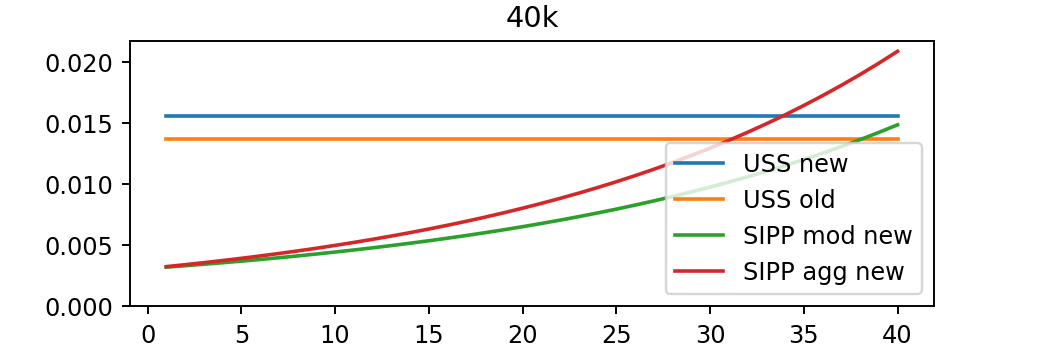

<IPython.core.display.Javascript object>


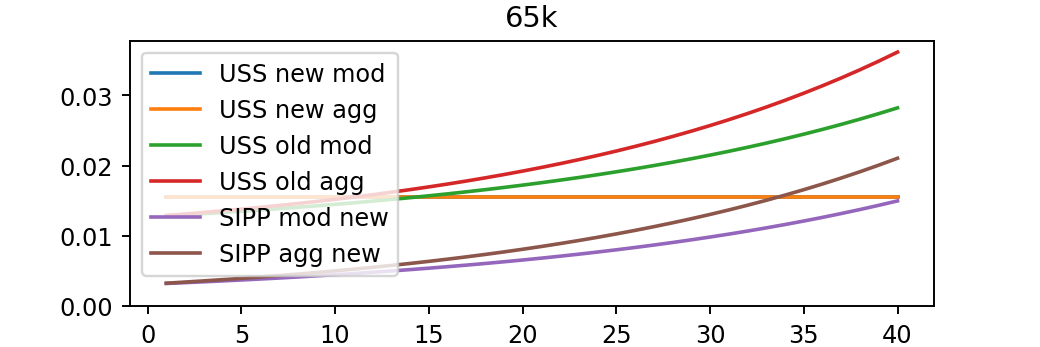

In [622]:
#40k salary
plt.figure(figsize=(6,2))
plt.title('40k')
plt.plot(yrs, pens_40k['uss_new'], label='USS new')
plt.plot(yrs, pens_40k['uss_old'], label='USS old')
plt.plot(yrs, pens_40k['sipp_mod'], label='SIPP mod new')
plt.plot(yrs, pens_40k['sipp_agg'], label='SIPP agg new')
plt.ylim(ymin=0)
plt.legend()

#65k salary
plt.figure(figsize=(6,2))
plt.title('65k')
plt.plot(yrs, pens_65k['uss_new_mod'], label='USS new mod')
plt.plot(yrs, pens_65k['uss_new_agg'], label='USS new agg')
plt.plot(yrs, pens_65k['uss_old_mod'], label='USS old mod')
plt.plot(yrs, pens_65k['uss_old_agg'], label='USS old agg')
plt.plot(yrs, pens_65k['sipp_mod'], label='SIPP mod new')
plt.plot(yrs, pens_65k['sipp_agg'], label='SIPP agg new')
plt.ylim(ymin=0)
plt.legend()

### Pension values as ratio of cost vs years to retirement

<IPython.core.display.Javascript object>


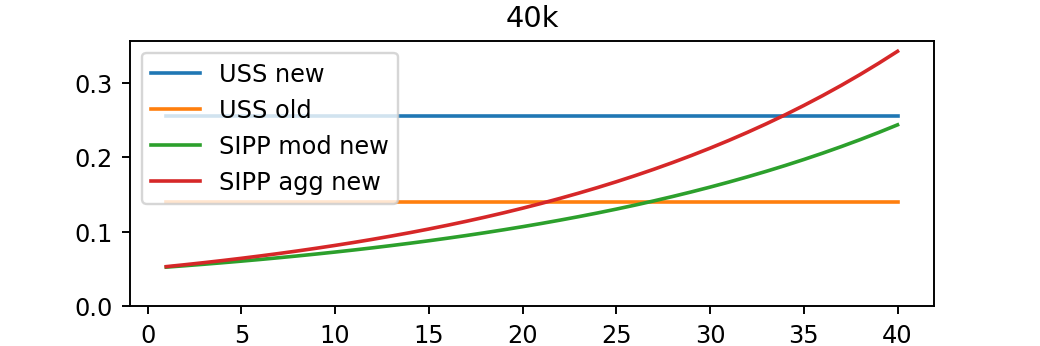

<IPython.core.display.Javascript object>


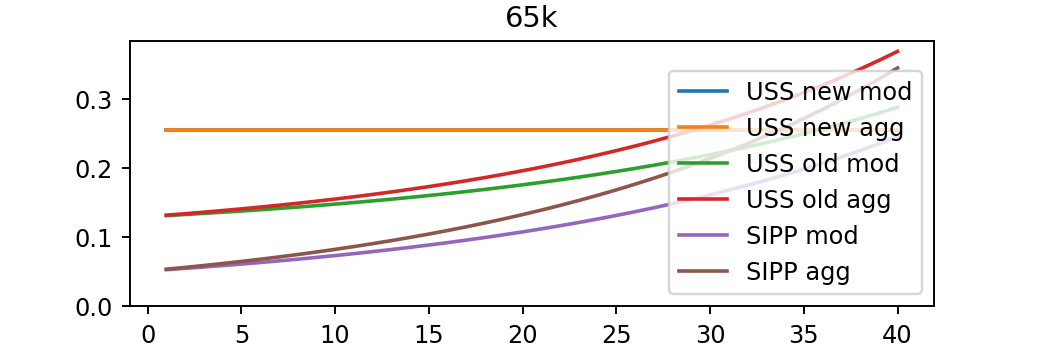

In [623]:
#40k salary
plt.figure(figsize=(6,2))
plt.title('40k')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_cost_new'], label='USS new')
plt.plot(yrs, pens_40k['uss_old']/pens_40k['uss_cost_old'], label='USS old')
plt.plot(yrs, pens_40k['sipp_mod']/pens_40k['uss_cost_new'], label='SIPP mod new')
plt.plot(yrs, pens_40k['sipp_agg']/pens_40k['uss_cost_new'], label='SIPP agg new')
plt.ylim(ymin=0)
plt.legend()

#65k salary
plt.figure(figsize=(6,2))
plt.title('65k')
plt.plot(yrs, pens_65k['uss_new_mod']/pens_65k['uss_cost_new'], label='USS new mod')
plt.plot(yrs, pens_65k['uss_new_agg']/pens_65k['uss_cost_new'], label='USS new agg')
plt.plot(yrs, pens_65k['uss_old_mod']/pens_65k['uss_cost_old'], label='USS old mod')
plt.plot(yrs, pens_65k['uss_old_agg']/pens_65k['uss_cost_old'], label='USS old agg')
plt.plot(yrs, pens_65k['sipp_mod']/pens_65k['uss_cost_new'], label='SIPP mod')
plt.plot(yrs, pens_65k['sipp_agg']/pens_65k['uss_cost_new'], label='SIPP agg')
plt.ylim(ymin=0)
plt.legend()

#### For USS, moderate portfolios only

<IPython.core.display.Javascript object>


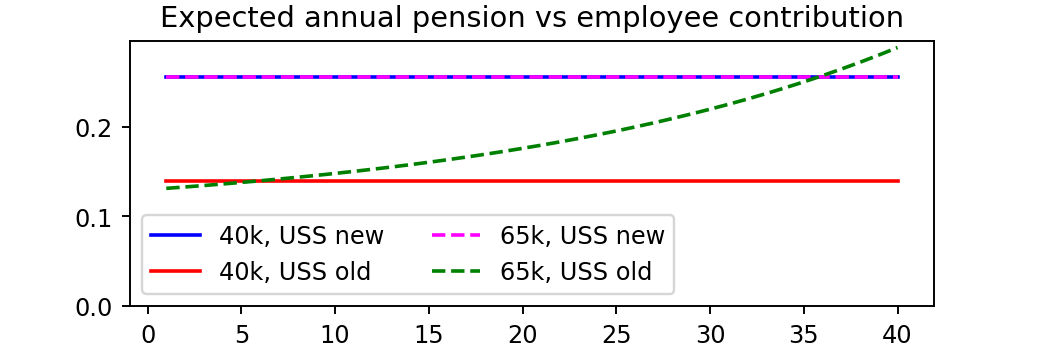

In [624]:
plt.figure(figsize=(6,2))
plt.title('Expected annual pension vs employee contribution')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_cost_new'], color='blue', label='40k, USS new')
plt.plot(yrs, pens_40k['uss_old']/pens_40k['uss_cost_old'], color='red', label='40k, USS old')
plt.plot(yrs, pens_65k['uss_new_mod']/pens_65k['uss_cost_new'], color='magenta', linestyle='--', label='65k, USS new')
plt.plot(yrs, pens_65k['uss_old_mod']/pens_65k['uss_cost_old'], color='green', linestyle='--', label='65k, USS old')
plt.ylim(ymin=0)
plt.legend(ncols=2)

#### For proposed USS scheme only
Using full scheme with 40k salary to represent DB pension, and showing the expected DC pension with the same contribution with moderate and 100% stocks portfolios.

<IPython.core.display.Javascript object>


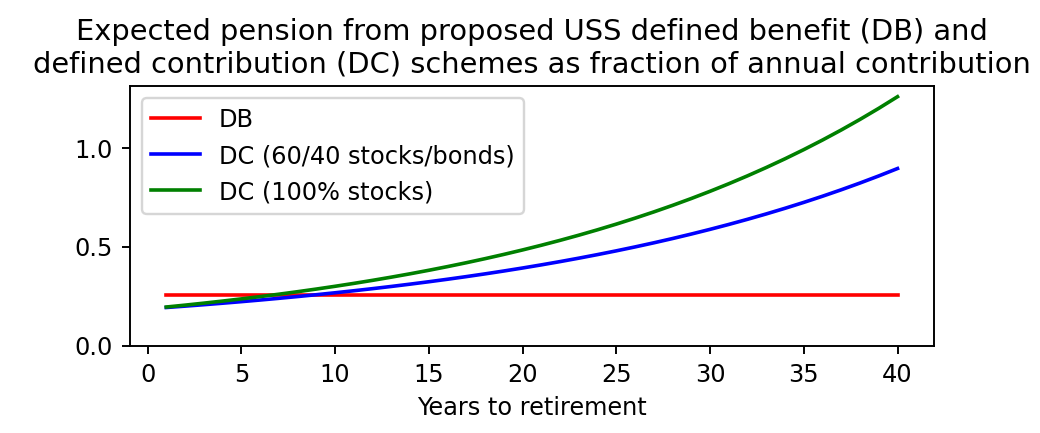

In [625]:
fig=plt.figure(figsize=(6,2.5))
plt.title('Expected pension from proposed USS defined benefit (DB) and\ndefined contribution (DC) schemes as fraction of annual contribution')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_cost_new'], color='red', label='DB')
plt.plot(yrs, pens_40k['uss_new_dc_equiv_mod']/pens_65k['uss_cost_new'], color='blue', label='DC (60/40 stocks/bonds)')
plt.plot(yrs, pens_40k['uss_new_dc_equiv_agg']/pens_65k['uss_cost_new'], color='green', label='DC (100% stocks)')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()
fig.subplots_adjust(top=0.8, bottom=0.2)

### Pension values as ratio of cost vs salary
For moderate portfolios

<IPython.core.display.Javascript object>


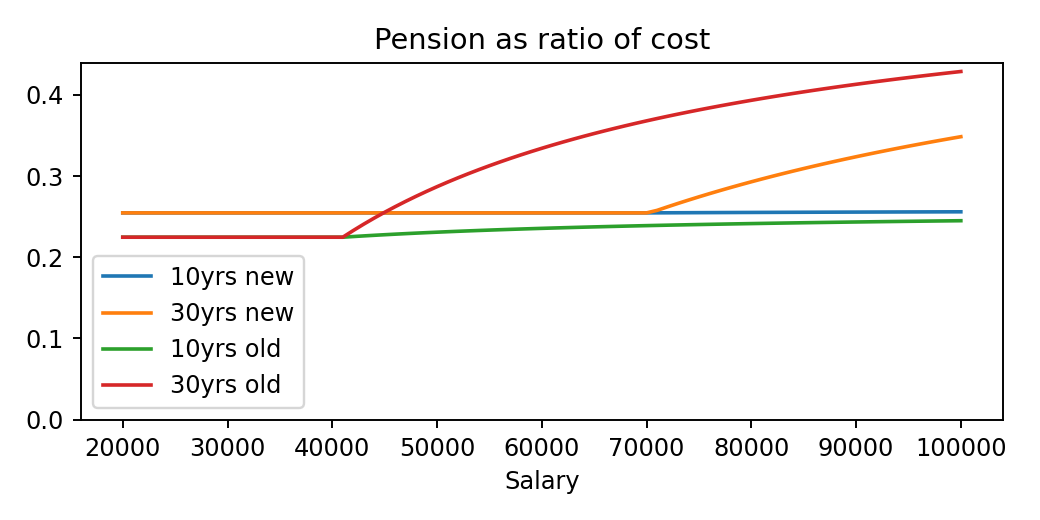

In [626]:
plt.figure(figsize=(6,3))
plt.title('Pension as ratio of cost')
plt.plot(salaries, pens_10yrs['uss_new_mod']/pens_cost_new, label='10yrs new')
plt.plot(salaries, pens_30yrs['uss_new_mod']/pens_cost_new, label='30yrs new')
plt.plot(salaries, pens_10yrs['uss_old_mod']/pens_cost_new, label='10yrs old')
plt.plot(salaries, pens_30yrs['uss_old_mod']/pens_cost_new, label='30yrs old')
plt.ylim(ymin=0)
plt.xlabel('Salary')
plt.legend()
plt.tight_layout()

### Ratios to SIPP vs time to retirement


#### For DB and DC scheme components
Using 40k salary pension values for DB scheme

<IPython.core.display.Javascript object>


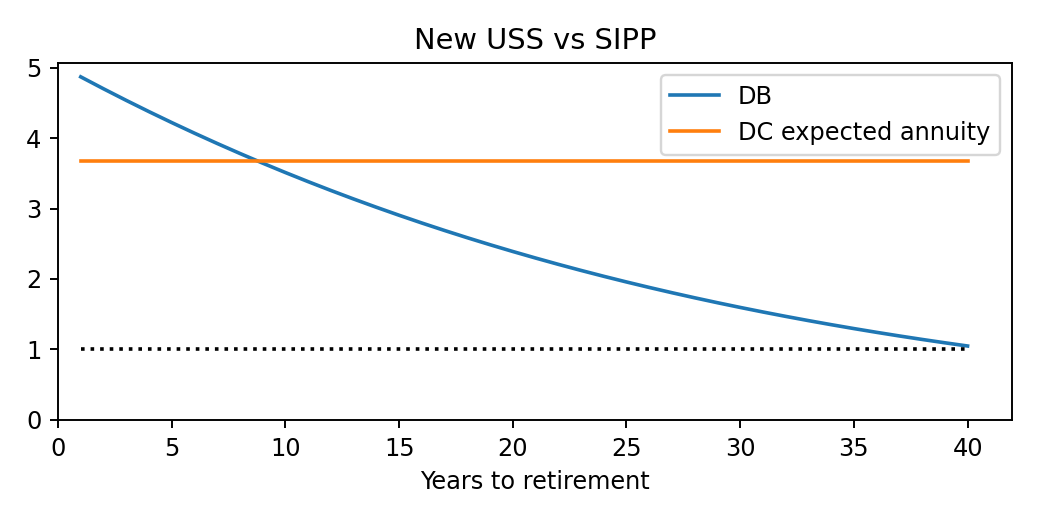

In [627]:
plt.figure(figsize=(6,3))
plt.title('New USS vs SIPP')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['sipp_mod'], label='DB')
plt.plot(yrs, pens_40k['uss_new_dc_equiv_mod']/pens_40k['sipp_mod'], label='DC expected annuity')
plt.plot(yrs,[1]*len(yrs), 'black', linestyle=':')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()
plt.tight_layout()

#### For all salaries and new and current schemes

<IPython.core.display.Javascript object>


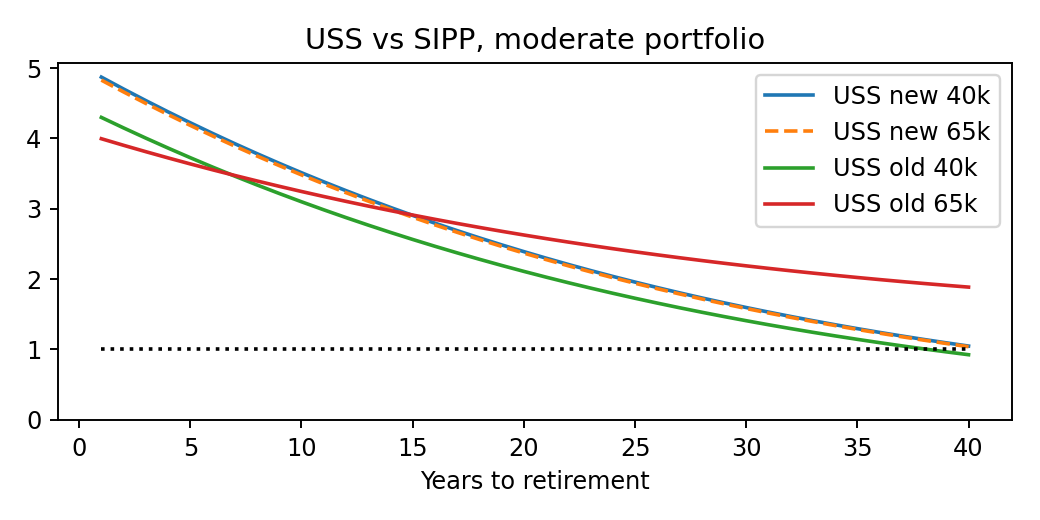

<IPython.core.display.Javascript object>


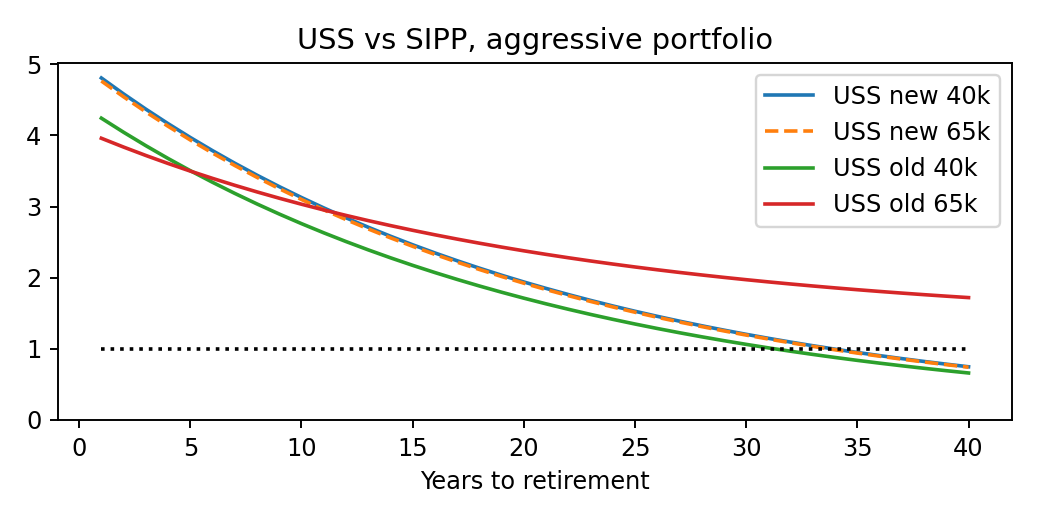

In [628]:
plt.figure(figsize=(6,3))
plt.title('USS vs SIPP, moderate portfolio')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['sipp_mod'], label='USS new 40k')
plt.plot(yrs, pens_65k['uss_new_mod']/pens_65k['sipp_mod'], '--', label='USS new 65k')
plt.plot(yrs, pens_40k['uss_old']/pens_40k['sipp_mod'], label='USS old 40k')
plt.plot(yrs, pens_65k['uss_old_mod']/pens_65k['sipp_mod'], label='USS old 65k')
plt.plot(yrs,[1]*len(yrs), 'black', linestyle=':')
plt.ylim(ymin=0)
plt.legend()
plt.xlabel('Years to retirement')
plt.tight_layout()

plt.figure(figsize=(6,3))
plt.title('USS vs SIPP, aggressive portfolio')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['sipp_agg'], label='USS new 40k')
plt.plot(yrs, pens_65k['uss_new_agg']/pens_65k['sipp_agg'], '--', label='USS new 65k')
plt.plot(yrs, pens_40k['uss_old']/pens_40k['sipp_agg'], label='USS old 40k')
plt.plot(yrs, pens_65k['uss_old_agg']/pens_65k['sipp_agg'], label='USS old 65k')
plt.plot(yrs,[1]*len(yrs), 'black', linestyle=':')
plt.ylim(ymin=0)
plt.legend()
plt.xlabel('Years to retirement')
plt.tight_layout()


### Ratio vs DC scheme
Using 40k salary pension values for DB scheme

<IPython.core.display.Javascript object>


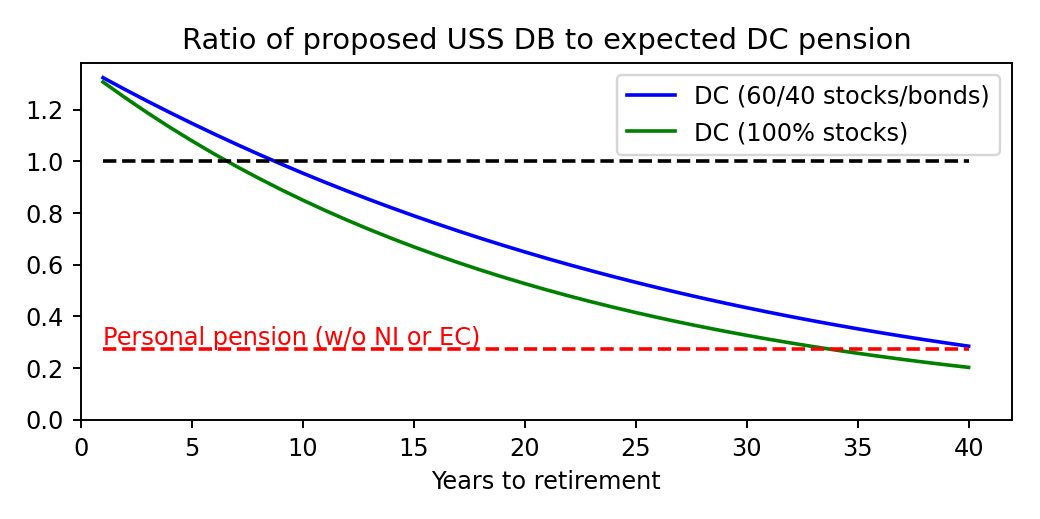

In [629]:
#For moderate portfolio
sipp_vs_dc_mod=pens_40k['sipp_mod']/pens_40k['uss_new_dc_equiv_mod']  #should be the same for 100% stocks portfolio - verified below
plt.figure(figsize=(6,3))
plt.title('Ratio of proposed USS DB to expected DC pension')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_new_dc_equiv_mod'], color='blue', label='DC (60/40 stocks/bonds)')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_new_dc_equiv_agg'], color='green', label='DC (100% stocks)')
plt.plot(yrs, sipp_vs_dc_mod, 'red', linestyle='--')
plt.text(yrs[0],sipp_vs_dc_mod[0],'Personal pension (w/o NI or EC)', verticalalignment='bottom', color='red')
plt.plot(yrs,[1]*len(yrs), 'black', linestyle='--')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()
plt.tight_layout()

In [630]:
#Checking that ratio for personal pension is the same for both moderate and aggressive portfolios (as it should be as it should just depend on the contribution rates and tax benefits)
sipp_vs_dc_agg=pens_40k['sipp_agg']/pens_40k['uss_new_dc_equiv_agg']
print(sipp_vs_dc_mod[[0,-1]],sipp_vs_dc_agg[[0,-1]])

[0.27174908 0.27174908] [0.27174908 0.27174908]


### New vs old scheme as function of salary
For 10 and 30 years to retirement

<IPython.core.display.Javascript object>


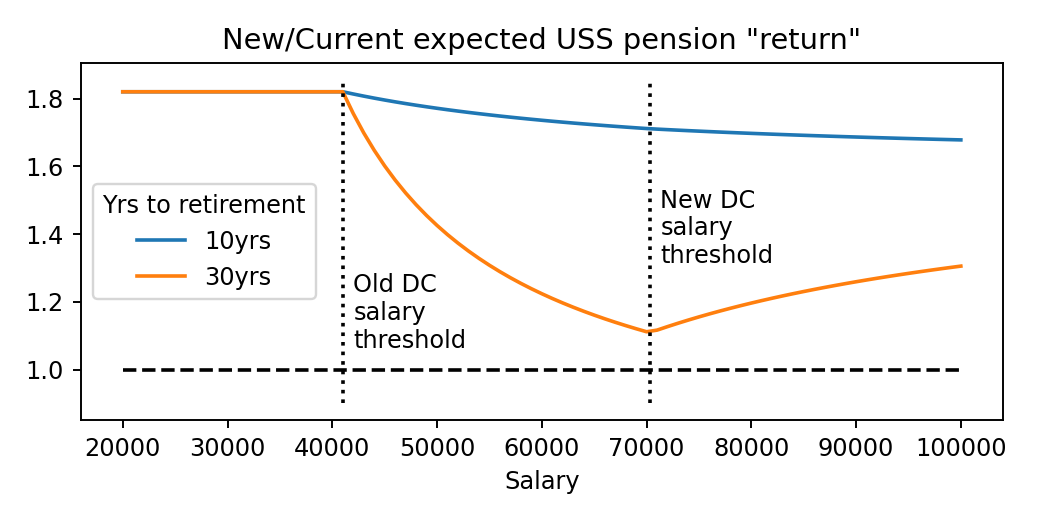

<IPython.core.display.Javascript object>


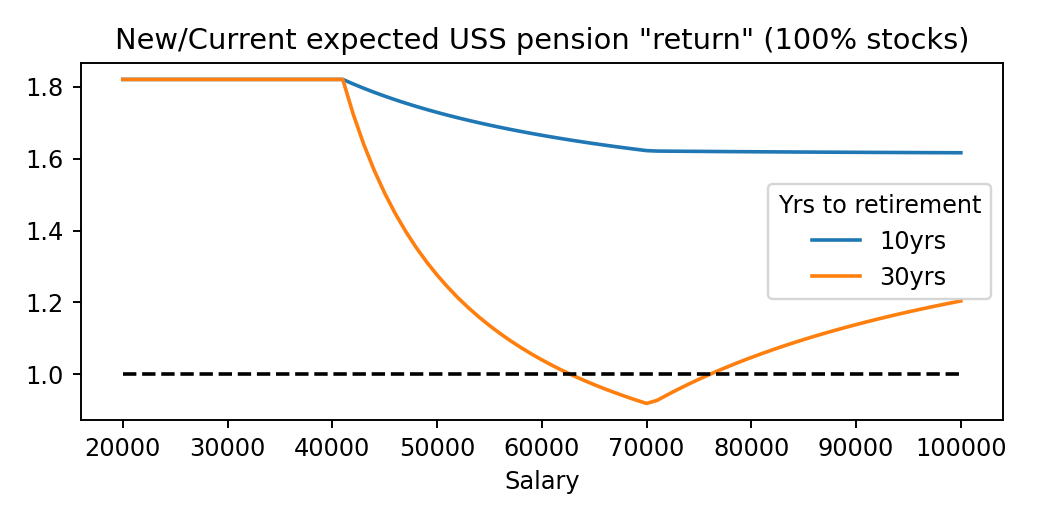

In [631]:
#Moderate portfolio
ratio_10_mod = (pens_10yrs['uss_new_mod']/pens_cost_new)/(pens_10yrs['uss_old_mod']/pens_cost_old)  #ratio of new and old pensions as proportion of cost
ratio_30_mod = (pens_30yrs['uss_new_mod']/pens_cost_new)/(pens_30yrs['uss_old_mod']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('New/Current expected USS pension "return"')
plt.plot(salaries, ratio_10_mod, label='10yrs')
plt.plot(salaries, ratio_30_mod, label='30yrs')
plt.plot(salaries,[1]*len(salaries),'k--')
ymax=np.max([ratio_10_mod,ratio_30_mod])
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+1000, 1.05, 'Old DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.3, 'New DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend(title='Yrs to retirement')
plt.tight_layout()

#Aggressive portfolio
ratio_10_agg = (pens_10yrs['uss_new_agg']/pens_cost_new)/(pens_10yrs['uss_old_agg']/pens_cost_old)  #ratio of new and old pensions as proportion of cost
ratio_30_agg = (pens_30yrs['uss_new_agg']/pens_cost_new)/(pens_30yrs['uss_old_agg']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('New/Current expected USS pension "return" (100% stocks)')
plt.plot(salaries, ratio_10_agg, label='10yrs')
plt.plot(salaries, ratio_30_agg, label='30yrs')
plt.plot(salaries,[1]*len(salaries),'k--')
plt.xlabel('Salary')
plt.legend(title='Yrs to retirement')
plt.tight_layout()

#### Showing results for moderate and aggressive portfolios on the same axes

<IPython.core.display.Javascript object>


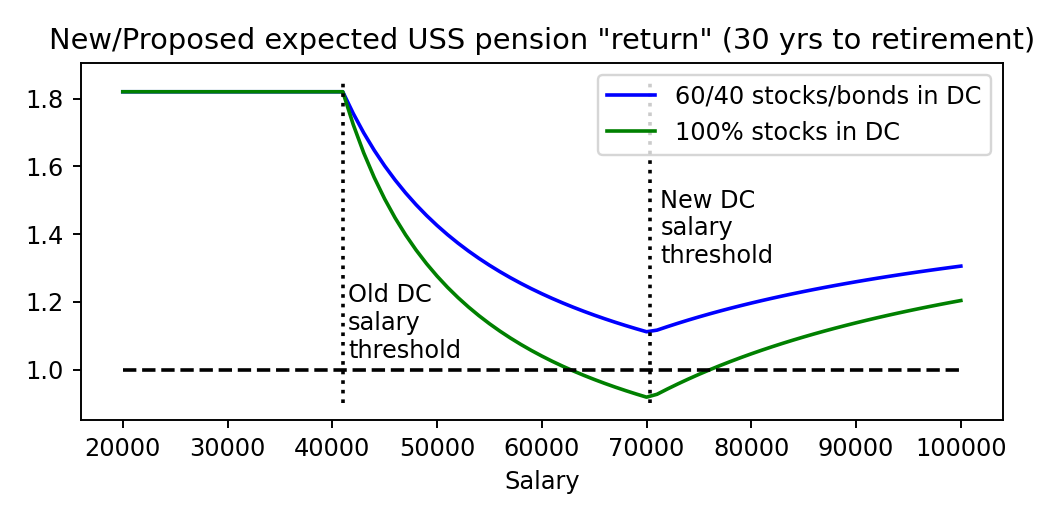

<IPython.core.display.Javascript object>


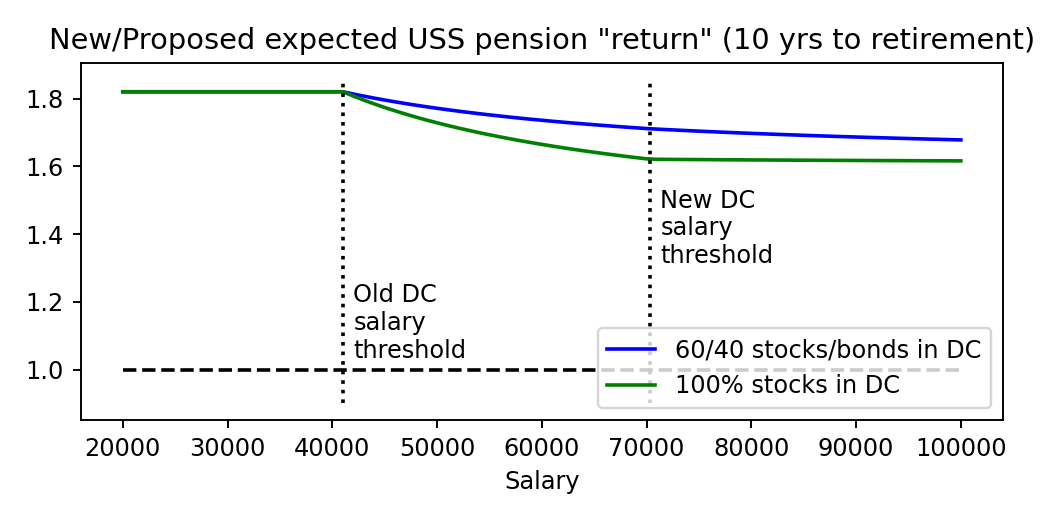

In [632]:
#30yrs to retirement
ratio_30_mod = (pens_30yrs['uss_new_mod']/pens_cost_new)/(pens_30yrs['uss_old_mod']/pens_cost_old) #ratio of new and old pensions as proportion of cost
ratio_30_agg = (pens_30yrs['uss_new_agg']/pens_cost_new)/(pens_30yrs['uss_old_agg']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('New/Proposed expected USS pension "return" (30 yrs to retirement)')
plt.plot(salaries, ratio_30_mod, color='blue', label='60/40 stocks/bonds in DC')
plt.plot(salaries, ratio_30_agg, color='green', label='100% stocks in DC')
plt.plot(salaries,[1]*len(salaries),'k--')
ymax=np.max([ratio_30_mod,ratio_30_agg])
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+500, 1.02, 'Old DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.3, 'New DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend()
plt.tight_layout()

#10 yrs to retirement
ratio_10_mod = (pens_10yrs['uss_new_mod']/pens_cost_new)/(pens_10yrs['uss_old_mod']/pens_cost_old)  
ratio_10_agg = (pens_10yrs['uss_new_agg']/pens_cost_new)/(pens_10yrs['uss_old_agg']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('New/Proposed expected USS pension "return" (10 yrs to retirement)')
plt.plot(salaries, ratio_10_mod, color='blue', label='60/40 stocks/bonds in DC')
plt.plot(salaries, ratio_10_agg, color='green', label='100% stocks in DC')
plt.plot(salaries,[1]*len(salaries),'k--')
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+1000, 1.02, 'Old DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.3, 'New DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend(loc="lower right")
plt.tight_layout()

### Time-adjusting the DB payout (scaling by expected investment return)

For moderate portfolio unless otherwise stated

#### Pension values as ratio of cost vs years to retirement 

<IPython.core.display.Javascript object>


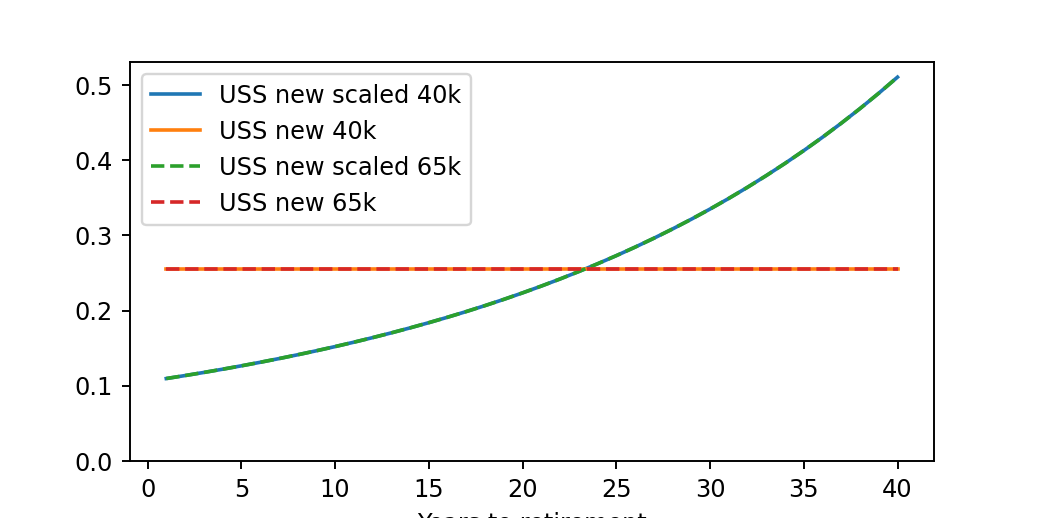

In [633]:
plt.figure(figsize=(6,3))
plt.plot(yrs, pens_40k['uss_new_db_scaled_mod']/pens_40k['uss_cost_new'], label='USS new scaled 40k')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_cost_new'], label='USS new 40k')
plt.plot(yrs, pens_65k['uss_new_db_scaled_mod']/pens_65k['uss_cost_new'], linestyle='--', label='USS new scaled 65k')
plt.plot(yrs, pens_65k['uss_new_mod']/pens_65k['uss_cost_new'], linestyle='--', label='USS new 65k')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

#### Pension values as ratio of cost vs salary

<IPython.core.display.Javascript object>


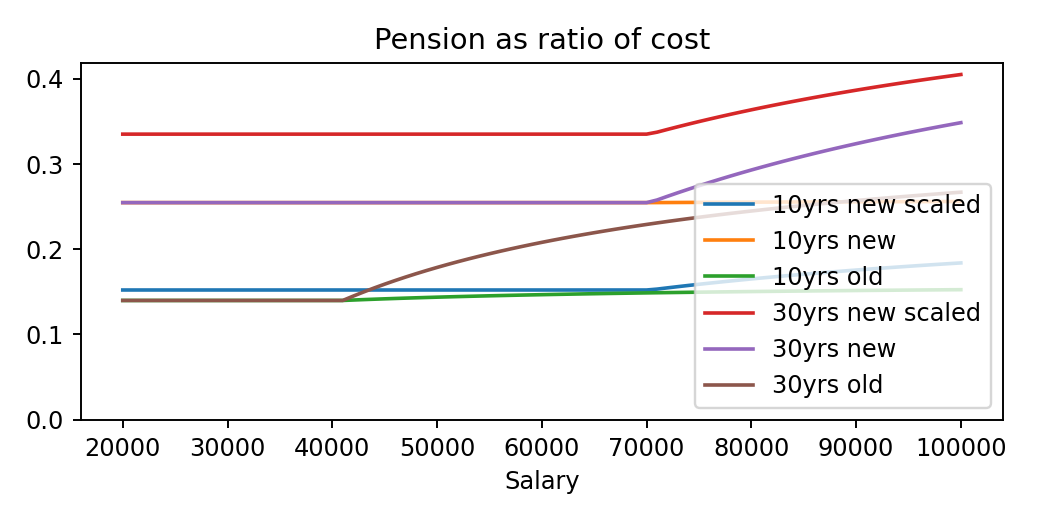

In [634]:
plt.figure(figsize=(6,3))
plt.title('Pension as ratio of cost')
plt.plot(salaries, pens_10yrs['uss_new_mod_scaled']/pens_cost_new, label='10yrs new scaled')
plt.plot(salaries, pens_10yrs['uss_new_mod']/pens_cost_new, label='10yrs new')
plt.plot(salaries, pens_10yrs['uss_old_mod']/pens_cost_old, label='10yrs old')
plt.plot(salaries, pens_30yrs['uss_new_mod_scaled']/pens_cost_new, label='30yrs new scaled')
plt.plot(salaries, pens_30yrs['uss_new_mod']/pens_cost_new, label='30yrs new')
plt.plot(salaries, pens_30yrs['uss_old_mod']/pens_cost_old, label='30yrs old')
plt.ylim(ymin=0)
plt.xlabel('Salary')
plt.legend()
plt.tight_layout()

#### Ratio wrt DC pension

<IPython.core.display.Javascript object>


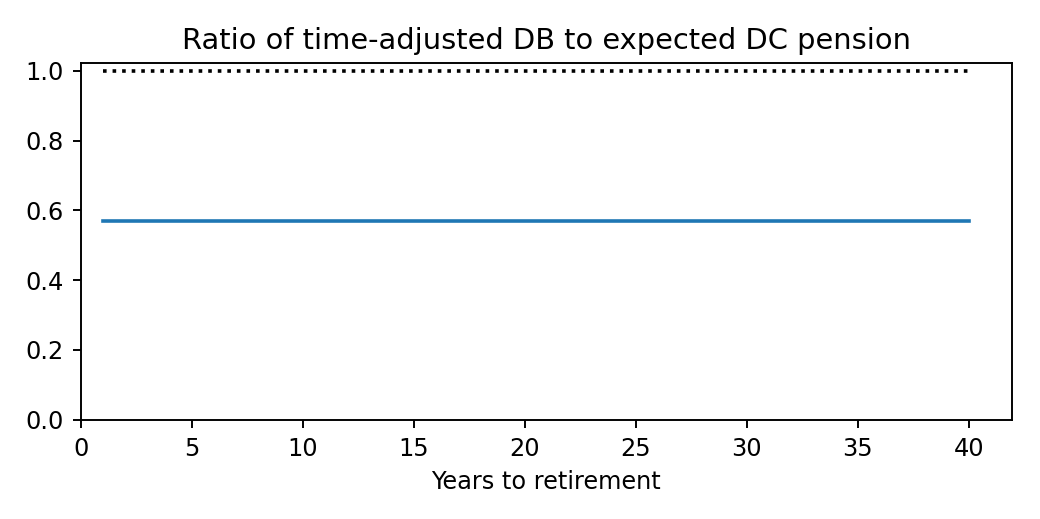

0.5700267452694702 0.5700267452694704


In [635]:
#Just showing for 40k salary, as this is representative of any salary below the salary threshold
uss_new_db_scaled_mod_vs_dc=pens_40k['uss_new_db_scaled_mod']/pens_40k['uss_new_dc_equiv_mod']
plt.figure(figsize=(6,3))
plt.title('Ratio of time-adjusted DB to expected DC pension')
plt.plot(yrs, uss_new_db_scaled_mod_vs_dc)
plt.plot(yrs,[1]*len(yrs), 'black', linestyle=':')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.tight_layout()
print(min(uss_new_db_scaled_mod_vs_dc),max(uss_new_db_scaled_mod_vs_dc))

For aggressive (100% stocks) portfolio:

In [636]:
uss_new_db_scaled_agg_vs_dc=pens_40k['uss_new_db_scaled_agg']/pens_40k['uss_new_dc_equiv_agg']
print(min(uss_new_db_scaled_agg_vs_dc),max(uss_new_db_scaled_agg_vs_dc))

0.44647969602655074 0.4464796960265509


These ratios are constant and less than 1: the 0.43-0.55 difference is the price to pay for a secure retirement income.

#### New vs old scheme as function of salary

##### For moderate portfolios

<IPython.core.display.Javascript object>


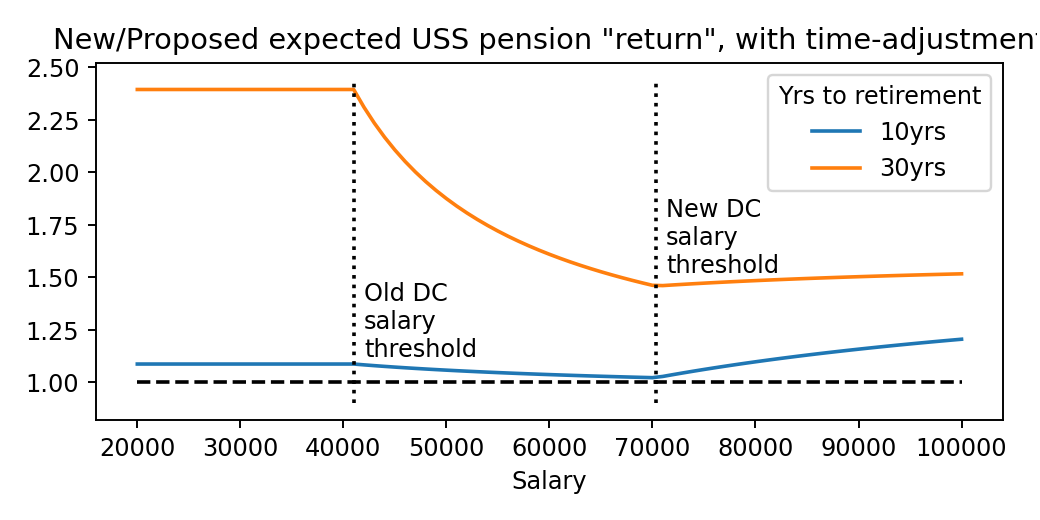

In [637]:
ratio_10_mod_scaled = (pens_10yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_10yrs['uss_old_mod']/pens_cost_old)  #ratio of new and old pensions as proportion of cost
ratio_30_mod_scaled = (pens_30yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_30yrs['uss_old_mod']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('New/Proposed expected USS pension "return", with time-adjustment')
plt.plot(salaries, ratio_10_mod_scaled, label='10yrs')
plt.plot(salaries, ratio_30_mod_scaled, label='30yrs')
plt.plot(salaries,[1]*len(salaries),'k--')
ymax=np.max([ratio_10_mod_scaled,ratio_30_mod_scaled])
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+1000, 1.1, 'Old DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.5, 'New DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend(title='Yrs to retirement')
plt.tight_layout()

##### At 30 yrs to retirement

<IPython.core.display.Javascript object>


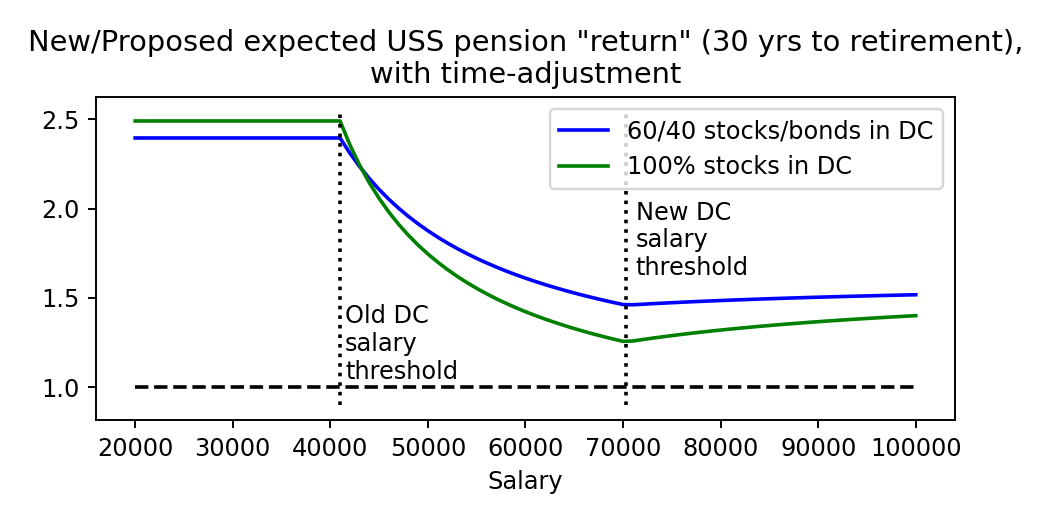

In [638]:
ratio_30_mod_scaled = (pens_30yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_30yrs['uss_old_mod']/pens_cost_old)
ratio_30_agg_scaled = (pens_30yrs['uss_new_agg_scaled']/pens_cost_new)/(pens_30yrs['uss_old_agg']/pens_cost_old)

fig=plt.figure(figsize=(6,3))
plt.title('New/Proposed expected USS pension "return" (30 yrs to retirement),\nwith time-adjustment')
plt.plot(salaries, ratio_30_mod_scaled, color='blue', label='60/40 stocks/bonds in DC')
plt.plot(salaries, ratio_30_agg_scaled, color='green', label='100% stocks in DC')
plt.plot(salaries,[1]*len(salaries),'k--')
ymax=np.max([ratio_30_mod_scaled,ratio_30_agg_scaled])
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+500, 1.02, 'Old DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.6, 'New DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend()
plt.tight_layout()
fig.subplots_adjust(right=0.92)

I think the decline above the old salary threshold here is due to the expected pension from the old scheme rising from here (see "Pension values as ratio of cost vs salary"), providing more per marginal unit of input than the scaled DB scheme (see "Ratio wrt DC pension" just above here), so the ratio decreases towards 1. Above the new salary threshold, in both cases it's the DC scheme that's being added to, so the ratio stays fairly steady and should tend to the ratio of contributions (0.098/0.061=1.61).

I think removing that dip would require lowering the DC salary threshold.

#### USS with vs without DB time-adjustment as function of salary

<IPython.core.display.Javascript object>


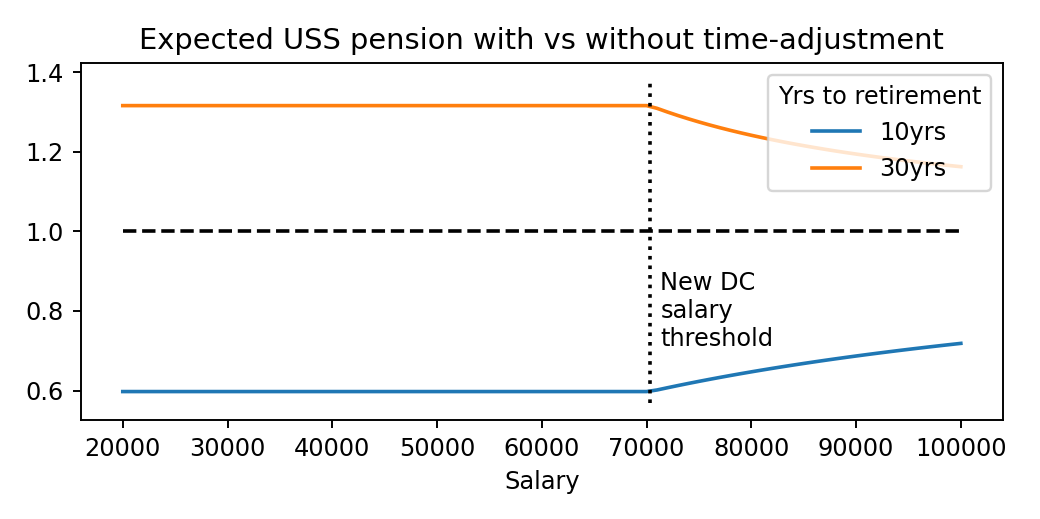

In [639]:
ratio_10_mod_scaled = (pens_10yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_10yrs['uss_new_mod']/pens_cost_new)  #ratio of new and old pensions as proportion of cost
ratio_30_mod_scaled = (pens_30yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_30yrs['uss_new_mod']/pens_cost_new)

plt.figure(figsize=(6,3))
plt.title('Expected USS pension with vs without time-adjustment')
plt.plot(salaries, ratio_10_mod_scaled, label='10yrs')
plt.plot(salaries, ratio_30_mod_scaled, label='30yrs')
plt.plot(salaries,[1]*len(salaries),'k--')
ymin=np.min([ratio_10_mod_scaled,ratio_30_mod_scaled])
ymax=np.max([ratio_10_mod_scaled,ratio_30_mod_scaled])
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [ymin*0.95,ymax*1.05], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 0.7, 'New DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend(title='Yrs to retirement')
plt.tight_layout()

## Some tests of the functions

4.820790883154125 4.820790883154125
6.776719779638552 6.776719779638552
1.8868975384274835 1.8868975384274835


<IPython.core.display.Javascript object>


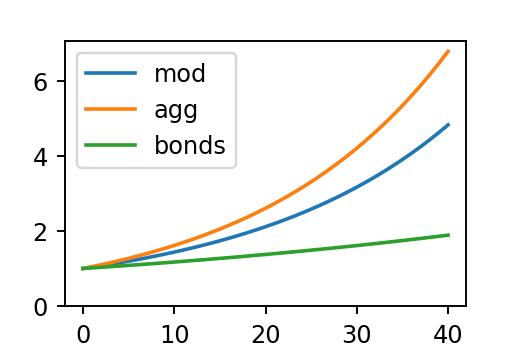

In [640]:
yrs=np.arange(41)
investment_value_mod = investment_value(0.6,yrs)
investment_value_agg = investment_value(1.0,yrs)
investment_value_bonds = investment_value(0.,yrs)

print(investment_value_mod[-1], 0.6*(1+eq_exp_growth)**yrs[-1]+0.4*(1+bonds_exp_growth)**yrs[-1])
print(investment_value_agg[-1], (1+eq_exp_growth)**yrs[-1])
print(investment_value_bonds[-1], (1+bonds_exp_growth)**yrs[-1])

plt.figure(figsize=(3,2))
plt.plot(investment_value_mod, label='mod')
plt.plot(investment_value_agg, label='agg')
plt.plot(investment_value_bonds, label='bonds')
plt.ylim(ymin=0)
plt.legend()

In [641]:
print(uss_ls(uss_new), 3/75.*annuity_yield)
print(uss_ls(uss_old), 3/85.*annuity_yield)

0.0022 0.0022
0.0019411764705882352 0.0019411764705882352


0.26514349857347685 0.26514349857347685
0.37271958788012033 0.37271958788012033
0.1037793646135116 0.1037793646135116

0.08917837837837839 0.08917837837837839

0.02364506724035255
0.03323852843700663
0.00925487544537143


<IPython.core.display.Javascript object>


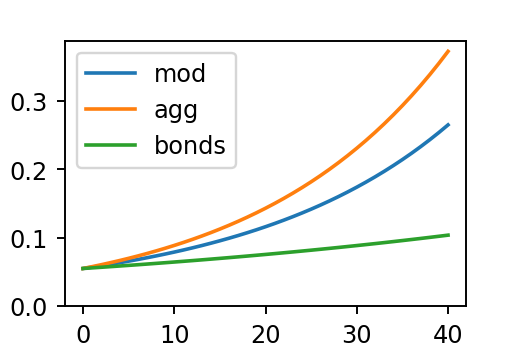

<IPython.core.display.Javascript object>


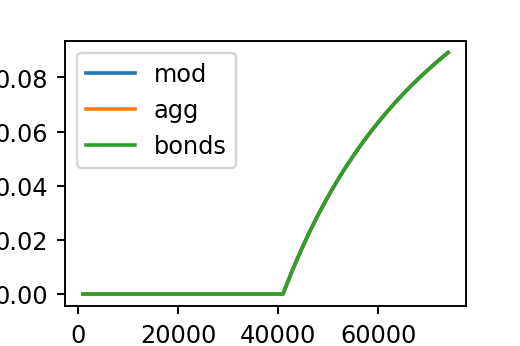

<IPython.core.display.Javascript object>


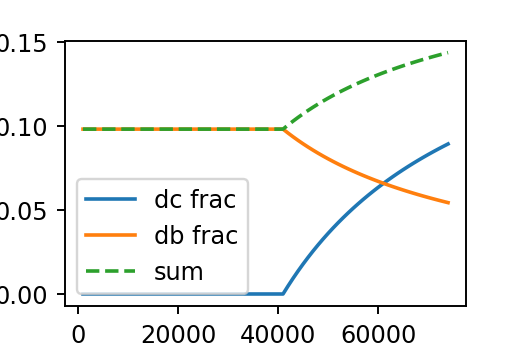

<IPython.core.display.Javascript object>


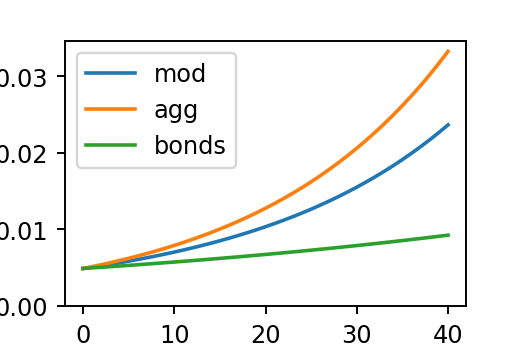

<IPython.core.display.Javascript object>


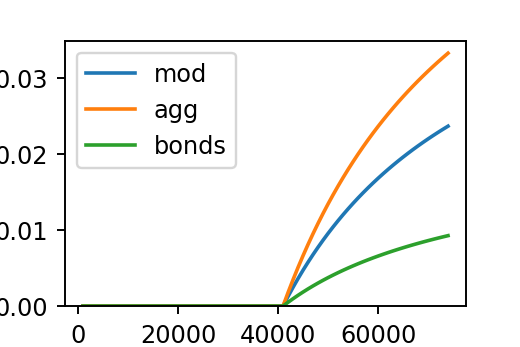

In [642]:
salaries=np.arange(1,75)*1000

uss_pens_dc_mod = np.zeros((len(salaries), len(yrs)))
dc_frac_mod = np.zeros((len(salaries), len(yrs)))
uss_pens_dc_agg = np.zeros((len(salaries), len(yrs)))
dc_frac_agg = np.zeros((len(salaries), len(yrs)))
uss_pens_dc_bonds = np.zeros((len(salaries), len(yrs)))
dc_frac_bonds = np.zeros((len(salaries), len(yrs)))

db_frac=np.zeros((len(salaries),))

for i,sal in enumerate(salaries):
    uss_pens_dc_mod[i], dc_frac_mod[i] = uss_dc(uss_old,sal,0.6,yrs)
    uss_pens_dc_agg[i], dc_frac_agg[i] = uss_dc(uss_old,sal,1.0,yrs)
    uss_pens_dc_bonds[i], dc_frac_bonds[i] = uss_dc(uss_old,sal,0.,yrs)
    db_frac[i]=uss_db_frac(uss_old,sal)

assert np.all(uss_pens_dc_mod[:,-1]==uss_pens_dc_mod[0,-1])
assert np.all(uss_pens_dc_agg[:,-1]==uss_pens_dc_agg[0,-1])
assert np.all(uss_pens_dc_bonds[:,-1]==uss_pens_dc_bonds[0,-1])
print(uss_pens_dc_mod[0,-1], investment_value(0.6,yrs[-1])*annuity_yield)
print(uss_pens_dc_agg[0,-1], investment_value(1.0,yrs[-1])*annuity_yield)
print(uss_pens_dc_bonds[0,-1], investment_value(0.,yrs[-1])*annuity_yield)

assert(np.all(dc_frac_mod==dc_frac_agg) and np.all(dc_frac_mod==dc_frac_bonds))
assert(np.all(dc_frac_mod[0,:]==dc_frac_mod[0]))
assert(np.all(dc_frac_mod[-1,:]==dc_frac_mod[-1]))
print()
print(dc_frac_mod[-1,0], (0.08+0.12)*(74000-uss_old['sal_thres'])/74000)

print()
print(uss_pens_dc_mod[-1,-1]*dc_frac_mod[-1,-1])
print(uss_pens_dc_agg[-1,-1]*dc_frac_agg[-1,-1])
print(uss_pens_dc_bonds[-1,-1]*dc_frac_bonds[-1,-1])

plt.figure(figsize=(3,2))
plt.plot(yrs, uss_pens_dc_mod[0], label='mod')
plt.plot(yrs, uss_pens_dc_agg[0], label='agg')
plt.plot(yrs, uss_pens_dc_bonds[0], label='bonds')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3,2))
plt.plot(salaries, dc_frac_mod[:,0], label='mod')
plt.plot(salaries, dc_frac_agg[:,0], label='agg')
plt.plot(salaries, dc_frac_bonds[:,0], label='bonds')
plt.legend()

plt.figure(figsize=(3,2))
plt.plot(salaries, dc_frac_mod[:,0], label='dc frac')
plt.plot(salaries, db_frac, label='db frac')
plt.plot(salaries, dc_frac_mod[:,0]+db_frac, '--', label='sum')
plt.legend()

plt.figure(figsize=(3,2))
plt.plot(yrs, uss_pens_dc_mod[-1]*dc_frac_mod[-1], label='mod')
plt.plot(yrs, uss_pens_dc_agg[-1]*dc_frac_agg[-1], label='agg')
plt.plot(yrs, uss_pens_dc_bonds[-1]*dc_frac_bonds[-1], label='bonds')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3,2))
plt.plot(salaries, uss_pens_dc_mod[:,-1]*dc_frac_mod[:,-1], label='mod')
plt.plot(salaries, uss_pens_dc_agg[:,-1]*dc_frac_agg[:,-1], label='agg')
plt.plot(salaries, uss_pens_dc_bonds[:,-1]*dc_frac_bonds[:,-1], label='bonds')
plt.ylim(ymin=0)
plt.legend()

[40000 65000]
0.015533333333333335 0.015533333333333335
0.013705882352941175 0.013705882352941175 0.013705882352941175
0.012706953846153845 0.012706953846153845
1272.4766783538303 1272.47667835383
0.03616541301775805
0.04083306897754717 0.007594540540540541 0.03323852843700663 0.04083306897754717


<IPython.core.display.Javascript object>


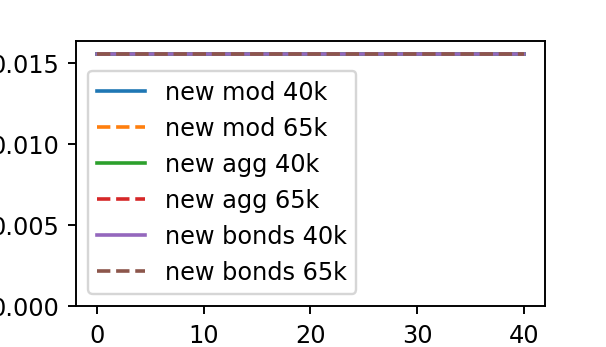

<IPython.core.display.Javascript object>


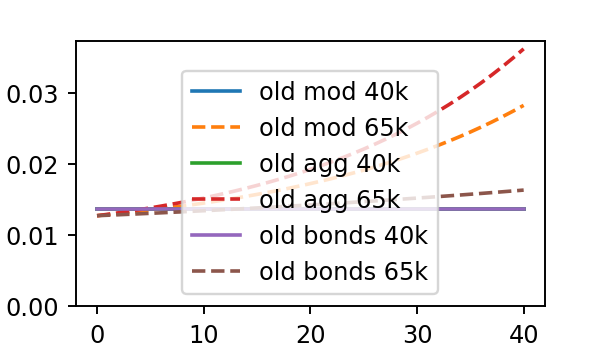

<IPython.core.display.Javascript object>


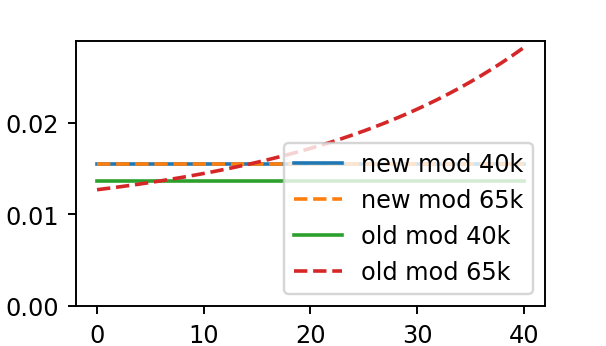

<IPython.core.display.Javascript object>


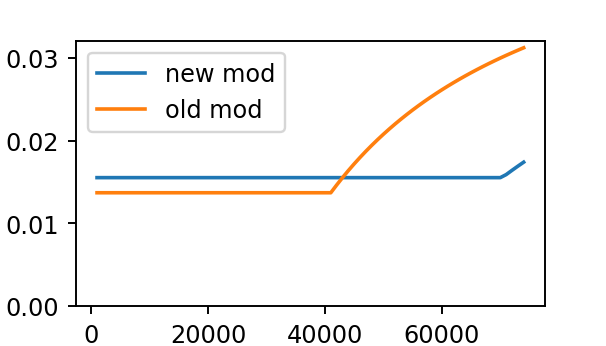

In [643]:
print(salaries[[39,64]])

uss_pens_new_mod=np.zeros((len(salaries), len(yrs)))
uss_pens_old_mod=np.zeros((len(salaries), len(yrs)))
uss_pens_new_agg=np.zeros((len(salaries), len(yrs)))
uss_pens_old_agg=np.zeros((len(salaries), len(yrs)))
uss_pens_new_bonds=np.zeros((len(salaries), len(yrs)))
uss_pens_old_bonds=np.zeros((len(salaries), len(yrs)))
for i,sal in enumerate(salaries):
    uss_pens_new_mod[i]=uss_pens(uss_new,sal,0.6,yrs)
    uss_pens_old_mod[i]=uss_pens(uss_old,sal,0.6,yrs)
    uss_pens_new_agg[i]=uss_pens(uss_new,sal,1.0,yrs)
    uss_pens_old_agg[i]=uss_pens(uss_old,sal,1.0,yrs)
    uss_pens_new_bonds[i]=uss_pens(uss_new,sal,0.,yrs)
    uss_pens_old_bonds[i]=uss_pens(uss_old,sal,0.,yrs)

assert np.all(uss_pens_new_mod[:65]==uss_pens_new_mod[0,0])
print(uss_pens_new_mod[0,0], 1/75.+3/75.*annuity_yield)
print(uss_pens_old_mod[39,0], uss_pens_old_mod[39,-1], 1/85.+3/85.*annuity_yield)
print(uss_pens_old_mod[64,0], (1/85.+3/85.*annuity_yield)*uss_old['sal_thres']/65000 + dc_frac_mod[64,0]*uss_dc_mod[64,0])  #pension as fraction of salary at 0 years until retirement is DB fraction times the salary threshold as a fraction of total salary plus the total DC contribution, with zero investment growth. 
print(uss_pens_old_mod[64,-1]*65000-uss_pens_old_mod[39,-1]*uss_old['sal_thres'], (65000-uss_old['sal_thres'])*0.2*investment_value(0.6,yrs[-1])*annuity_yield)  #absolute pension payment (in £) coming from annuity bought from payments into DC scheme at £65k salary (i.e. total pension minus the defined benefit that applies up to the salary threshold)
print(uss_pens_old_agg[64,-1])  #should be the highest pension value plotted below
print(uss_pens_old_agg[-1,-1], (1/85.+3/85.*annuity_yield)*uss_old['sal_thres']/salaries[-1], dc_frac_agg[-1,-1]*uss_pens_dc_agg[-1,-1], (1/85.+3/85.*annuity_yield)*uss_old['sal_thres']/salaries[-1] + dc_frac_agg[-1,-1]*uss_pens_dc_agg[-1,-1])  #first value should be the highest pension value in the arrays. The next values are the components and the sum to check they're equal to the first value.

plt.figure(figsize=(3.5,2))
plt.plot(yrs,uss_pens_new_mod[39], label='new mod 40k')
plt.plot(yrs,uss_pens_new_mod[64], '--', label='new mod 65k')
plt.plot(yrs,uss_pens_new_agg[39], label='new agg 40k')
plt.plot(yrs,uss_pens_new_agg[64], '--', label='new agg 65k')
plt.plot(yrs,uss_pens_new_bonds[39], label='new bonds 40k')
plt.plot(yrs,uss_pens_new_bonds[64], '--', label='new bonds 65k')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs,uss_pens_old_mod[39], label='old mod 40k')
plt.plot(yrs,uss_pens_old_mod[64], '--', label='old mod 65k')
plt.plot(yrs,uss_pens_old_agg[39], label='old agg 40k')
plt.plot(yrs,uss_pens_old_agg[64], '--', label='old agg 65k')
plt.plot(yrs,uss_pens_old_bonds[39], label='old bonds 40k')
plt.plot(yrs,uss_pens_old_bonds[64], '--', label='old bonds 65k')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs,uss_pens_new_mod[39], label='new mod 40k')
plt.plot(yrs,uss_pens_new_mod[64], '--', label='new mod 65k')
plt.plot(yrs,uss_pens_old_mod[39], label='old mod 40k')
plt.plot(yrs,uss_pens_old_mod[64], '--', label='old mod 65k')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(salaries,uss_pens_new_mod[:,-1], label='new mod')
plt.plot(salaries,uss_pens_old_mod[:,-1], label='old mod')
plt.ylim(ymin=0)
plt.legend()

<IPython.core.display.Javascript object>


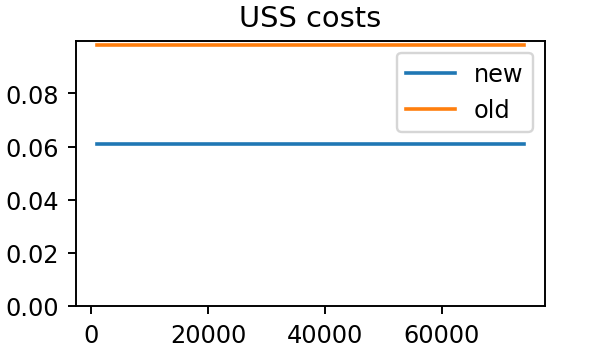

In [644]:
uss_cost_new=np.zeros((len(salaries),))
uss_cost_old=np.zeros((len(salaries),))
for i,sal in enumerate(salaries):
    uss_cost_new[i]=uss_cost(uss_new,sal)
    uss_cost_old[i]=uss_cost(uss_old,sal)

plt.figure(figsize=(3.5,2))
plt.title('USS costs')
plt.plot(salaries,uss_cost_new, label='new')
plt.plot(salaries,uss_cost_old, label='old')
plt.ylim(ymin=0)
plt.legend()    

0.05461956070613623 0.05461956070613623
0.07678023510330478 0.0767802351033048


<IPython.core.display.Javascript object>


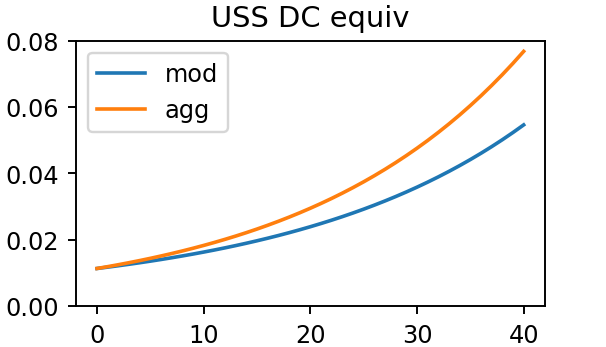

In [645]:
uss_dc_equiv_new=np.zeros((len(yrs),))
uss_dc_equiv_new_mod=uss_dc_equiv(uss_new,0.6,yrs)
uss_dc_equiv_new_agg=uss_dc_equiv(uss_new,1.0,yrs)

print(uss_dc_equiv_new_mod[-1], (uss_new['db_cont']+uss_new['db_empl'])*investment_value(0.6,yrs[-1])*annuity_yield)
print(uss_dc_equiv_new_agg[-1], (uss_new['db_cont']+uss_new['db_empl'])*investment_value(1.0,yrs[-1])*annuity_yield)

plt.figure(figsize=(3.5,2))
plt.title('USS DC equiv')
plt.plot(yrs,uss_dc_equiv_new_mod, label='mod')
plt.plot(yrs,uss_dc_equiv_new_agg, label='agg')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

<IPython.core.display.Javascript object>


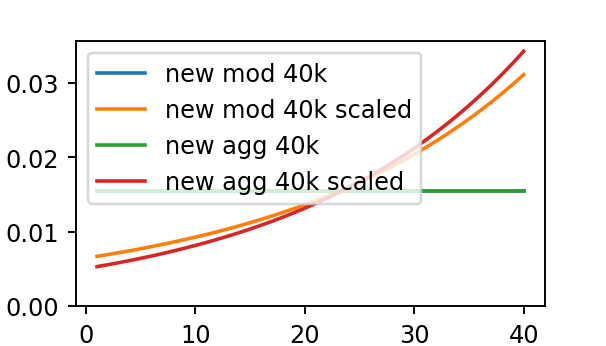

<IPython.core.display.Javascript object>


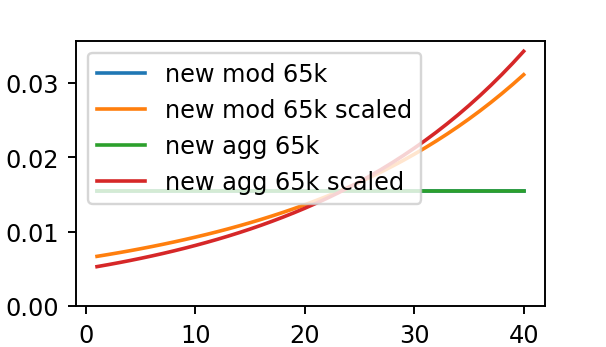

<IPython.core.display.Javascript object>


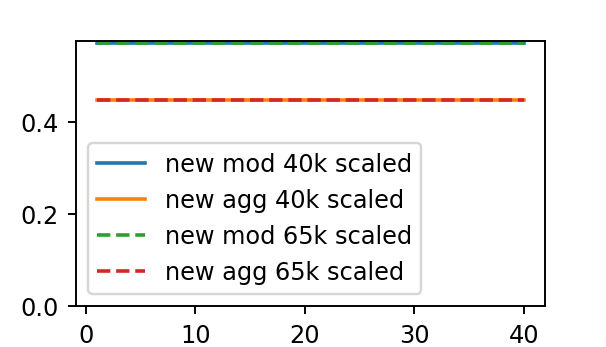

<IPython.core.display.Javascript object>


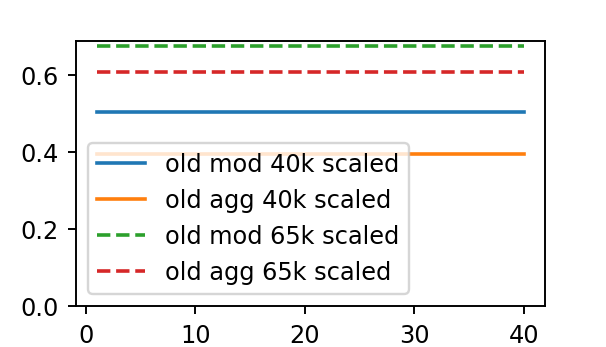

In [646]:
#Testing scaling USS pension by expected DC investment return - for arrays of years to retirement

yrs_from_1=np.arange(40)+1  #use years axis starting at 1 to match that used in normalisation in uss_pens() for scaled DB part, to enable comparison with using a single year value in the cell below
uss_pens_new_40k_mod_scaled=uss_pens(uss_new,salaries[39],0.6,yrs_from_1,scale_by_inv_return=True)
uss_pens_old_40k_mod_scaled=uss_pens(uss_old,salaries[39],0.6,yrs_from_1,scale_by_inv_return=True)
uss_pens_new_40k_agg_scaled=uss_pens(uss_new,salaries[39],1.0,yrs_from_1,scale_by_inv_return=True)
uss_pens_old_40k_agg_scaled=uss_pens(uss_old,salaries[39],1.0,yrs_from_1,scale_by_inv_return=True)
uss_pens_new_65k_mod_scaled=uss_pens(uss_new,salaries[64],0.6,yrs_from_1,scale_by_inv_return=True)
uss_pens_old_65k_mod_scaled=uss_pens(uss_old,salaries[64],0.6,yrs_from_1,scale_by_inv_return=True)
uss_pens_new_65k_agg_scaled=uss_pens(uss_new,salaries[64],1.0,yrs_from_1,scale_by_inv_return=True)
uss_pens_old_65k_agg_scaled=uss_pens(uss_old,salaries[64],1.0,yrs_from_1,scale_by_inv_return=True)

plt.figure(figsize=(3.5,2))
plt.plot(yrs_from_1,uss_pens_new_mod[39,1:], label='new mod 40k')
plt.plot(yrs_from_1,uss_pens_new_40k_mod_scaled, label='new mod 40k scaled')
plt.plot(yrs_from_1,uss_pens_new_agg[39,1:], label='new agg 40k')
plt.plot(yrs_from_1,uss_pens_new_40k_agg_scaled, label='new agg 40k scaled')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs_from_1,uss_pens_new_mod[64,1:], label='new mod 65k')
plt.plot(yrs_from_1,uss_pens_new_65k_mod_scaled, label='new mod 65k scaled')
plt.plot(yrs_from_1,uss_pens_new_agg[64,1:], label='new agg 65k')
plt.plot(yrs_from_1,uss_pens_new_65k_agg_scaled, label='new agg 65k scaled')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

#Plots of ratios of scaled DB pensions to DC expected pension should be flat
plt.figure(figsize=(3.5,2))
plt.plot(yrs_from_1,uss_pens_new_40k_mod_scaled/uss_dc_equiv_new_mod[1:], label='new mod 40k scaled')
plt.plot(yrs_from_1,uss_pens_new_40k_agg_scaled/uss_dc_equiv_new_agg[1:], label='new agg 40k scaled')
plt.plot(yrs_from_1,uss_pens_new_65k_mod_scaled/uss_dc_equiv_new_mod[1:], label='new mod 65k scaled', linestyle='--')
plt.plot(yrs_from_1,uss_pens_new_65k_agg_scaled/uss_dc_equiv_new_agg[1:], label='new agg 65k scaled', linestyle='--')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs_from_1,uss_pens_old_40k_mod_scaled/uss_dc_equiv_new_mod[1:], label='old mod 40k scaled')
plt.plot(yrs_from_1,uss_pens_old_40k_agg_scaled/uss_dc_equiv_new_agg[1:], label='old agg 40k scaled')
plt.plot(yrs_from_1,uss_pens_old_65k_mod_scaled/uss_dc_equiv_new_mod[1:], label='old mod 65k scaled', linestyle='--')
plt.plot(yrs_from_1,uss_pens_old_65k_agg_scaled/uss_dc_equiv_new_agg[1:], label='old agg 65k scaled', linestyle='--')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

In [647]:
#Testing scaling USS pension by expected DC investment return - for single value of years to retirement
#Check the ratio is the same as for the corresponding value in the arrays calculated with multiple years
uss_pens_new_40k_mod_scaled_10=uss_pens(uss_new,salaries[39],0.6,10,scale_by_inv_return=True)
uss_pens_old_40k_mod_scaled_10=uss_pens(uss_old,salaries[39],0.6,10,scale_by_inv_return=True)
uss_pens_new_65k_mod_scaled_10=uss_pens(uss_new,salaries[64],0.6,10,scale_by_inv_return=True)
uss_pens_old_65k_mod_scaled_10=uss_pens(uss_old,salaries[64],0.6,10,scale_by_inv_return=True)
uss_pens_new_40k_mod_scaled_30=uss_pens(uss_new,salaries[39],0.6,30,scale_by_inv_return=True)
uss_pens_old_40k_mod_scaled_30=uss_pens(uss_old,salaries[39],0.6,30,scale_by_inv_return=True)
uss_pens_new_65k_mod_scaled_30=uss_pens(uss_new,salaries[64],0.6,30,scale_by_inv_return=True)
uss_pens_old_65k_mod_scaled_30=uss_pens(uss_old,salaries[64],0.6,30,scale_by_inv_return=True)

print(yrs_from_1[9],yrs_from_1[29])  #should be 10, 30
print(uss_pens_new_40k_mod_scaled_10, uss_pens_new_40k_mod_scaled[9])
print(uss_pens_old_40k_mod_scaled_10, uss_pens_old_40k_mod_scaled[9])
print(uss_pens_new_65k_mod_scaled_10, uss_pens_new_65k_mod_scaled[9])
print(uss_pens_old_65k_mod_scaled_10, uss_pens_old_65k_mod_scaled[9])
print(uss_pens_new_40k_mod_scaled_30, uss_pens_new_40k_mod_scaled[29])
print(uss_pens_old_40k_mod_scaled_30, uss_pens_old_40k_mod_scaled[29])
print(uss_pens_new_65k_mod_scaled_30, uss_pens_new_65k_mod_scaled[29])
print(uss_pens_old_65k_mod_scaled_30, uss_pens_old_65k_mod_scaled[29])

10 30
0.009279942497132428 0.009279942497132428
0.008188184556293322 0.00818818455629332
0.009279942497132428 0.009279942497132428
0.011000324685910414 0.011000324685910412
0.020434822440408614 0.020434822440408614
0.018030725682713484 0.018030725682713484
0.020434822440408614 0.020434822440408614
0.024223176147145805 0.024223176147145805


<IPython.core.display.Javascript object>


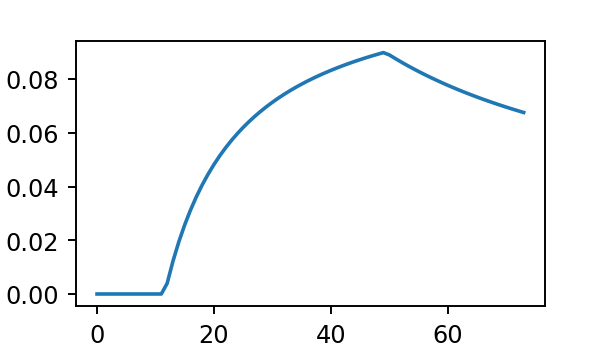

<IPython.core.display.Javascript object>


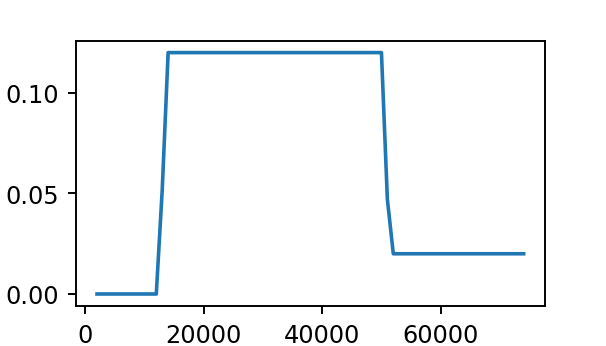

In [648]:
ni_vals=np.zeros(len(salaries))
for i,sal in enumerate(salaries):
    ni_vals[i]=ni(sal)

plt.figure(figsize=(3.5,2))
plt.plot(ni_vals)

#Should return the percentage of salary taken by NI
ni_amounts=ni_vals*salaries
ni_rates=(ni_amounts[1:]-ni_amounts[:-1])/(salaries[1:]-salaries[:-1])
plt.figure(figsize=(3.5,2))
plt.plot(salaries[1:],ni_rates)

<IPython.core.display.Javascript object>


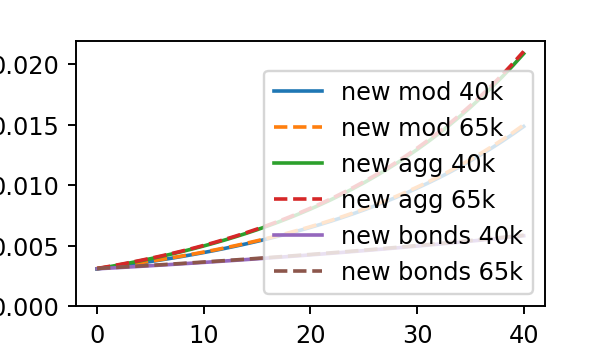

<IPython.core.display.Javascript object>


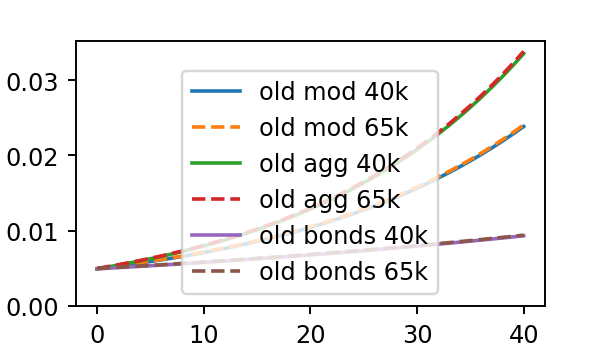

<IPython.core.display.Javascript object>


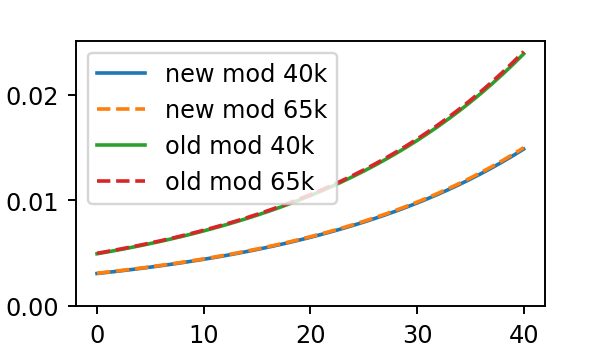

0.6224489795918368 0.6224489795918366 0.6224489795918366


<IPython.core.display.Javascript object>


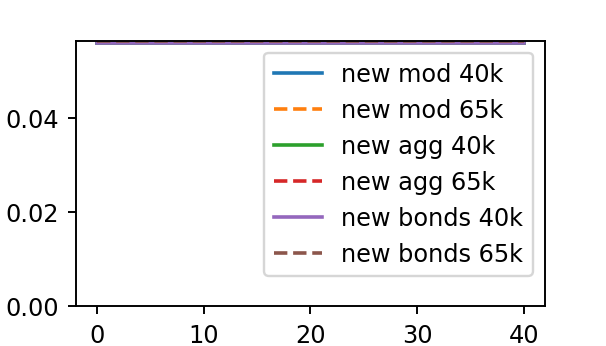

<IPython.core.display.Javascript object>


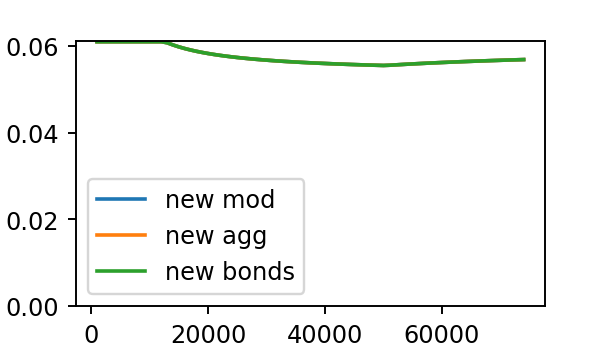

In [649]:
sipp_pens_new_mod=np.zeros((len(salaries), len(yrs)))
sipp_pens_old_mod=np.zeros((len(salaries), len(yrs)))
sipp_pens_new_agg=np.zeros((len(salaries), len(yrs)))
sipp_pens_old_agg=np.zeros((len(salaries), len(yrs)))
sipp_pens_new_bonds=np.zeros((len(salaries), len(yrs)))
sipp_pens_old_bonds=np.zeros((len(salaries), len(yrs)))
for i,sal in enumerate(salaries):
    sipp_pens_new_mod[i]=sipp_pens(uss_new,sal,0.6,yrs)
    sipp_pens_old_mod[i]=sipp_pens(uss_old,sal,0.6,yrs)
    sipp_pens_new_agg[i]=sipp_pens(uss_new,sal,1.0,yrs)
    sipp_pens_old_agg[i]=sipp_pens(uss_old,sal,1.0,yrs)
    sipp_pens_new_bonds[i]=sipp_pens(uss_new,sal,0.,yrs)
    sipp_pens_old_bonds[i]=sipp_pens(uss_old,sal,0.,yrs)

plt.figure(figsize=(3.5,2))
plt.plot(yrs,sipp_pens_new_mod[39], label='new mod 40k')
plt.plot(yrs,sipp_pens_new_mod[64], '--', label='new mod 65k')
plt.plot(yrs,sipp_pens_new_agg[39], label='new agg 40k')
plt.plot(yrs,sipp_pens_new_agg[64], '--', label='new agg 65k')
plt.plot(yrs,sipp_pens_new_bonds[39], label='new bonds 40k')
plt.plot(yrs,sipp_pens_new_bonds[64], '--', label='new bonds 65k')
plt.ylim(ymin=0)
plt.legend()

#Values for old scheme should be scaled up compared to above curves by ratio of contribution rates (given that 65k is below salary threshold for the new scheme)
plt.figure(figsize=(3.5,2))
plt.plot(yrs,sipp_pens_old_mod[39], label='old mod 40k')
plt.plot(yrs,sipp_pens_old_mod[64], '--', label='old mod 65k')
plt.plot(yrs,sipp_pens_old_agg[39], label='old agg 40k')
plt.plot(yrs,sipp_pens_old_agg[64], '--', label='old agg 65k')
plt.plot(yrs,sipp_pens_old_bonds[39], label='old bonds 40k')
plt.plot(yrs,sipp_pens_old_bonds[64], '--', label='old bonds 65k')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs,sipp_pens_new_mod[39], label='new mod 40k')
plt.plot(yrs,sipp_pens_new_mod[64], '--', label='new mod 65k')
plt.plot(yrs,sipp_pens_old_mod[39], label='old mod 40k')
plt.plot(yrs,sipp_pens_old_mod[64], '--', label='old mod 65k')
plt.ylim(ymin=0)
plt.legend()

print(sipp_pens_new_mod[39,-1]/sipp_pens_old_mod[39,-1], sipp_pens_new_mod[64,-1]/sipp_pens_old_mod[64,-1], uss_new['db_cont']/uss_old['db_cont'])


#Ratio with respect to DC value:

#should be constant with respect to time to retirement
plt.figure(figsize=(3.5,2))
plt.plot(yrs,sipp_pens_new_mod[39]/uss_pens_dc_mod[39], label='new mod 40k')
plt.plot(yrs,sipp_pens_new_mod[64]/uss_pens_dc_mod[64], '--', label='new mod 65k')
plt.plot(yrs,sipp_pens_new_agg[39]/uss_pens_dc_agg[39], label='new agg 40k')
plt.plot(yrs,sipp_pens_new_agg[64]/uss_pens_dc_agg[64], '--', label='new agg 65k')
plt.plot(yrs,sipp_pens_new_bonds[39]/uss_pens_dc_bonds[39], label='new bonds 40k')
plt.plot(yrs,sipp_pens_new_bonds[64]/uss_pens_dc_bonds[64], '--', label='new bonds 65k')
plt.ylim(ymin=0)
plt.legend()

#should drop by the NI rate as salary increases above the threshold
plt.figure(figsize=(3.5,2))
plt.plot(salaries,sipp_pens_new_mod[:,-1]/uss_pens_dc_mod[:,-1], label='new mod')
plt.plot(salaries,sipp_pens_new_agg[:,-1]/uss_pens_dc_agg[:,-1], label='new agg')
plt.plot(salaries,sipp_pens_new_bonds[:,-1]/uss_pens_dc_bonds[:,-1], label='new bonds')
plt.ylim(ymin=0)
plt.legend()

<IPython.core.display.Javascript object>


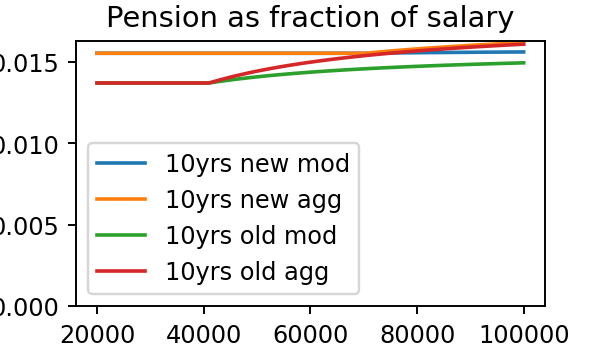

<IPython.core.display.Javascript object>


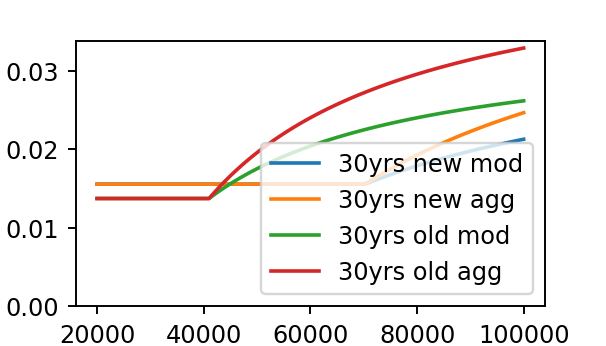

<IPython.core.display.Javascript object>


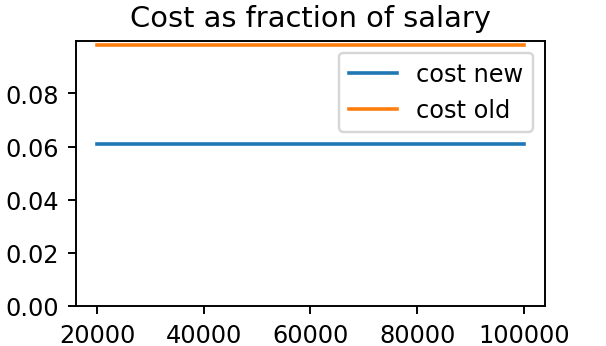

<IPython.core.display.Javascript object>


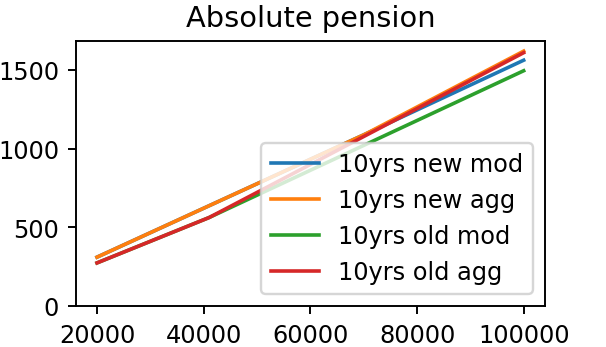

<IPython.core.display.Javascript object>


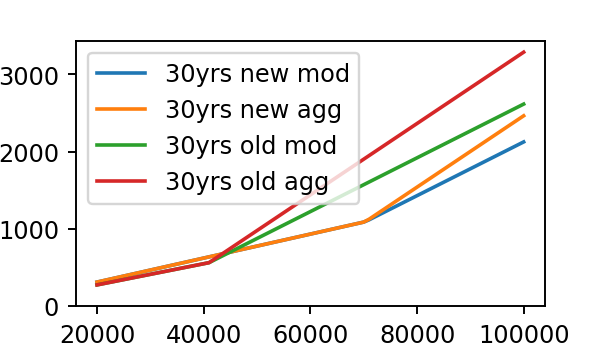

In [650]:
#Checking calculation of pension vs salary

salaries=np.arange(20,101,1)*1000

plt.figure(figsize=(3.5,2))
plt.title('Pension as fraction of salary')
plt.plot(salaries,pens_10yrs['uss_new_mod'],label='10yrs new mod')
plt.plot(salaries,pens_10yrs['uss_new_agg'],label='10yrs new agg')
plt.plot(salaries,pens_10yrs['uss_old_mod'],label='10yrs old mod')
plt.plot(salaries,pens_10yrs['uss_old_agg'],label='10yrs old agg')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(salaries,pens_30yrs['uss_new_mod'],label='30yrs new mod')
plt.plot(salaries,pens_30yrs['uss_new_agg'],label='30yrs new agg')
plt.plot(salaries,pens_30yrs['uss_old_mod'],label='30yrs old mod')
plt.plot(salaries,pens_30yrs['uss_old_agg'],label='30yrs old agg')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.title('Cost as fraction of salary')
plt.plot(salaries,pens_cost_new,label='cost new')
plt.plot(salaries,pens_cost_old,label='cost old')
plt.ylim(ymin=0)
plt.legend()

#Check absolute pension values (fractions multiplied by salary) are straight lines above the salary threshold
plt.figure(figsize=(3.5,2))
plt.title('Absolute pension')
plt.plot(salaries,pens_10yrs['uss_new_mod']*salaries,label='10yrs new mod')
plt.plot(salaries,pens_10yrs['uss_new_agg']*salaries,label='10yrs new agg')
plt.plot(salaries,pens_10yrs['uss_old_mod']*salaries,label='10yrs old mod')
plt.plot(salaries,pens_10yrs['uss_old_agg']*salaries,label='10yrs old agg')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(salaries,pens_30yrs['uss_new_mod']*salaries,label='30yrs new mod')
plt.plot(salaries,pens_30yrs['uss_new_agg']*salaries,label='30yrs new agg')
plt.plot(salaries,pens_30yrs['uss_old_mod']*salaries,label='30yrs old mod')
plt.plot(salaries,pens_30yrs['uss_old_agg']*salaries,label='30yrs old agg')
plt.ylim(ymin=0)
plt.legend()
